## 0. Classification Starter

In [1]:
import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

import util

sns.set()

In [2]:
def extract_feats(ffs, direc="data/train", global_feat_dict=None):
    """
    arguments:
      ffs are a list of feature-functions.
      direc is a directory containing xml files (expected to be train or test).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that 
      the columns of the test matrix align correctly.

    returns: 
      a sparse design matrix, a dict mapping features to column-numbers,
      a vector of target classes, and a list of system-call-history ids in order 
      of their rows in the design matrix.
      
      Note: the vector of target classes returned will contain the true indices of the
      target classes on the training data, but will contain only -1's on the test
      data
    """
    fds = [] # list of feature dicts
    classes = []
    ids = [] 
    for datafile in os.listdir(direc):
        # extract id and true class (if available) from filename
        id_str,clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))
        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)
        rowfd = {}
        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        # accumulate features
        [rowfd.update(ff(tree)) for ff in ffs]
        fds.append(rowfd)
    
    X,feat_dict = make_design_mat(fds,global_feat_dict)
    return X, feat_dict, np.array(classes), ids

In [3]:
def make_design_mat(fds, global_feat_dict=None):
    """
    arguments:
      fds is a list of feature dicts (one for each row).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that 
      the columns of the test matrix align correctly.
       
    returns: 
        a sparse NxD design matrix, where N == len(fds) and D is the number of
        the union of features defined in any of the fds 
    """
    if global_feat_dict is None:
        all_feats = set()
        [all_feats.update(fd.keys()) for fd in fds]
        feat_dict = dict([(feat, i) for i, feat in enumerate(sorted(all_feats))])
    else:
        feat_dict = global_feat_dict
    
    cols = []
    rows = []
    data = []        
    for i in range(len(fds)): #xrange deprecated in Python 3.x
        temp_cols = []
        temp_data = []
        for feat,val in fds[i].items():
            try:
                # update temp_cols iff update temp_data
                temp_cols.append(feat_dict[feat])
                temp_data.append(val)
            except KeyError as ex:
                if global_feat_dict is not None:
                    pass  # new feature in test data; nbd
                else:
                    raise ex

        # all fd's features in the same row
        k = len(temp_cols)
        cols.extend(temp_cols)
        data.extend(temp_data)
        rows.extend([i]*k)

    assert len(cols) == len(rows) and len(rows) == len(data)
   
    X = sparse.csr_matrix((np.array(data),
                   (np.array(rows), np.array(cols))),
                   shape=(len(fds), len(feat_dict)))
    return X, feat_dict

In [4]:
## Here are two example feature-functions. They each take an xml.etree.ElementTree object, 
# (i.e., the result of parsing an xml file) and returns a dictionary mapping 
# feature-names to numeric values.
## TODO: modify these functions, and/or add new ones.
def first_last_system_call_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'first_call-x' to 1 if x was the first system call
      made, and 'last_call-y' to 1 if y was the last system call made. 
      (in other words, it returns a dictionary indicating what the first and 
      last system calls made by an executable were.)
    """
    c = Counter()
    in_all_section = False
    first = True # is this the first system call
    last_call = None # keep track of last call we've seen
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            if first:
                c["first_call-"+el.tag] = 1
                first = False
            last_call = el.tag  # update last call seen
            
    # finally, mark last call seen
    c["last_call-"+last_call] = 1
    return c

In [5]:
def system_call_count_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'num_system_calls' to the number of system_calls
      made by an executable (summed over all processes)
    """
    c = Counter()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            c['num_system_calls'] += 1
    return c

#  Main function

In [6]:
train_dir = "data/train"
test_dir = "data/test"
outputfile = "AC_predictions.csv"  # feel free to change this or take it as an argument

In [7]:
# TODO put the names of the feature functions you've defined above in this list
ffs = [first_last_system_call_feats, system_call_count_feats]

In [9]:
# extract features
print("extracting training features...")
X_train,global_feat_dict,t_train,train_ids = extract_feats(ffs, train_dir)

extracting training features...


In [10]:
y_train = np.zeros((len(t_train),len(util.malware_classes)))
y_train[np.arange(len(t_train)), t_train] = 1
y_train.shape

(3086, 15)

In [11]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(class_weight = "balanced", n_jobs = -1)
RF.fit(X_train, y_train)
print(RF.n_features_)
print(RF.feature_importances_)

31
[0.00000000e+00 9.87093711e-04 4.16541897e-03 2.21171725e-03
 1.51489779e-02 3.21681239e-03 4.15196110e-04 2.18523759e-02
 5.18435946e-04 3.31601510e-03 1.39839377e-04 2.51749889e-03
 3.06483954e-05 2.35602273e-02 1.67449266e-03 1.21653100e-02
 5.18995985e-04 1.36109100e-03 4.02774018e-05 1.75671991e-02
 1.22319247e-02 5.43771487e-03 2.47165408e-04 1.78366199e-04
 1.44996255e-03 1.11000984e-04 1.11427370e-02 1.52991902e-02
 3.43041724e-03 2.71681636e-05 8.39036729e-01]


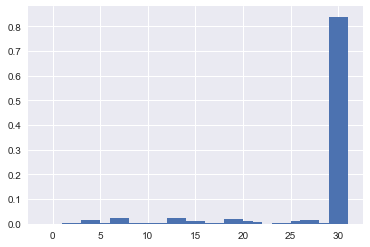

In [12]:
plt.bar(range(len(RF.feature_importances_)), RF.feature_importances_, 2)
#plt.yscale('symlog')
plt.show()

In [13]:
imp0 = np.flip(np.argsort(RF.feature_importances_),0)
print('Most important feature: ',list(global_feat_dict.keys())[list(global_feat_dict.values()).index(imp0[0])])

Most important feature:  num_system_calls


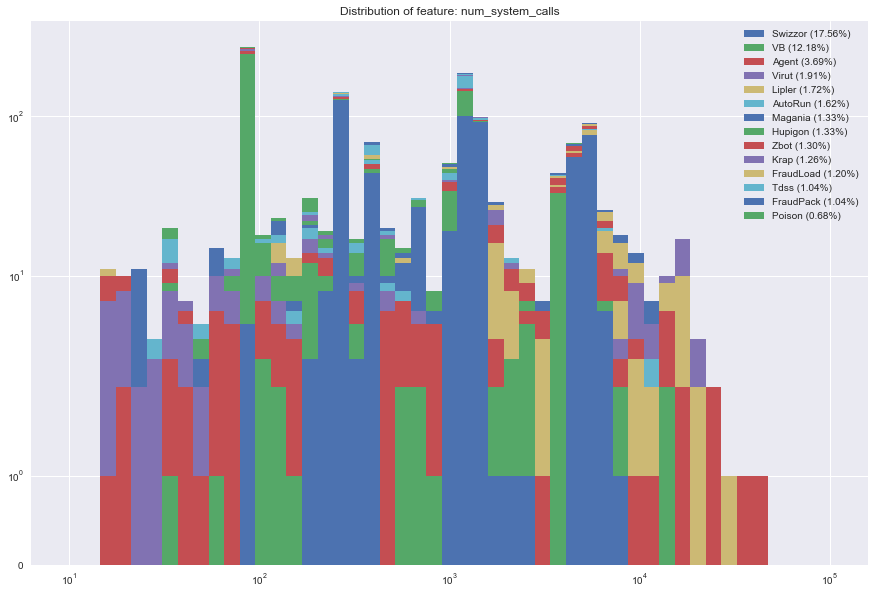

In [18]:
# Plot most important feature over histogram classes
plt.clf()
plt.figure(figsize=(15,10))
plt.rc('axes', labelsize=20)
feat_cts = []
label = []
iclass = np.flip(np.argsort(np.sum(y_train,axis=0)),0)[1:]
for i in iclass:
    feat_cts.append(X_train[y_train[:,i]==1,imp0[0]].toarray().T[0])
    label.append('{} ({:.2f}%)'.format(util.malware_classes[i],100*np.sum(y_train[:,i])/np.sum(y_train)))
plt.hist(feat_cts, bins=np.logspace(1,5,50),histtype='barstacked')
plt.title('Distribution of feature: '+list(global_feat_dict.keys())[list(global_feat_dict.values()).index(imp0[0])])
plt.xscale('log')
plt.yscale('symlog')
plt.legend(label)
plt.show()

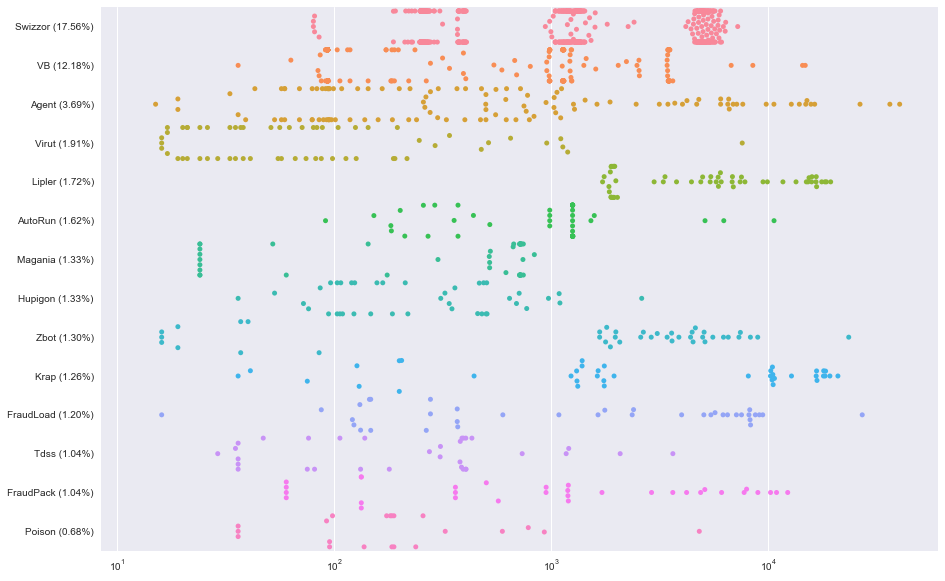

In [20]:
# Show distributions in swarmplot
plt.clf()
plt.figure(figsize=(15,10))
#sns.violinplot(data=feat_cts)
sns.swarmplot(data=feat_cts,orient='h')
plt.yticks(range(len(label)),label) #,rotation=30,ha='right')
plt.xscale('log')
plt.show()

In [29]:
import operator
sorted_global_feat_dict = sorted(global_feat_dict.items(), key=operator.itemgetter(1))
print(sorted_global_feat_dict)

[('first_call-load_image', 0), ('last_call-check_for_debugger', 1), ('last_call-create_mutex', 2), ('last_call-create_open_file', 3), ('last_call-create_thread', 4), ('last_call-create_window', 5), ('last_call-dump_line', 6), ('last_call-enum_window', 7), ('last_call-find_file', 8), ('last_call-get_file_attributes', 9), ('last_call-get_host_by_name', 10), ('last_call-get_system_directory', 11), ('last_call-get_system_time', 12), ('last_call-kill_process', 13), ('last_call-listen_socket', 14), ('last_call-load_dll', 15), ('last_call-load_driver', 16), ('last_call-open_file', 17), ('last_call-open_key', 18), ('last_call-open_process', 19), ('last_call-process', 20), ('last_call-query_value', 21), ('last_call-read_value', 22), ('last_call-set_value', 23), ('last_call-set_windows_hook', 24), ('last_call-show_window', 25), ('last_call-sleep', 26), ('last_call-thread', 27), ('last_call-vm_protect', 28), ('last_call-write_value', 29), ('num_system_calls', 30)]


In [21]:
RF.score(X_train, y_train)

0.8933895009721322

In [53]:
# get rid of training data and load test data
# del X_train
# del t_train
# del train_ids

In [14]:
print("extracting test features...")
X_test,_,t_ignore,test_ids = extract_feats(ffs, test_dir, global_feat_dict=global_feat_dict)

extracting test features...


In [23]:
preds = RF.predict(X_test)

In [34]:
preds[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [35]:
# TODO make predictions on text data and write them out
print("making predictions...")
results = np.argmax(preds, axis=1)

print("writing predictions...")
util.write_predictions(results, test_ids, outputfile)

making predictions...
writing predictions...


In [24]:
import csv 
import sys 

def reorder_submission(file_to_reorder, newfile_name = "experiment_results.csv"):
    # READ IN KEYS IN CORRECT ORDER AS LIST
    with open('keys.csv','r') as f:
        keyreader = csv.reader(f)
        keys = [key[0] for key in keyreader]

    # READ IN ALL PREDICTIONS, REGARDLESS OF ORDER
    with open(file_to_reorder) as f:
        oldfile_reader = csv.reader(f)
        D = {}
        for i,row in enumerate(oldfile_reader):
            if i == 0:
                continue
            _id, pred = row 
            D[_id] = pred

    # WRITE PREDICTIONS IN NEW ORDER
    with open(newfile_name,'w') as f:
        writer = csv.writer(f)
        writer.writerow(('Id','Prediction'))
        for key in keys:
            writer.writerow((key,D[key]))

    print("".join(["Reordered ", file_to_reorder," and wrote to ", newfile_name]))

In [39]:
reorder_submission(outputfile, "AC_results_0.csv")

Reordered AC_predictions.csv and wrote to AC_results_0.csv


## 1. Exploratory Data Analysis

In [25]:
X_train.shape

(3086, 31)

In [41]:
help(util)

Help on module util:

NAME
    util - # these are the fifteen malware classes we're looking for

FUNCTIONS
    write_predictions(predictions, ids, outfile)
        assumes len(predictions) == len(ids), and that predictions[i] is the
        index of the predicted class with the malware_classes list above for 
        the executable corresponding to ids[i].
        outfile will be overwritten

DATA
    malware_classes = ['Agent', 'AutoRun', 'FraudLoad', 'FraudPack', 'Hupi...

FILE
    /Users/copete/Documents/Classes/18SP CS 181 Machine Learning/P2_dualspace/Antonio/util.py




In [42]:
util.malware_classes

['Agent',
 'AutoRun',
 'FraudLoad',
 'FraudPack',
 'Hupigon',
 'Krap',
 'Lipler',
 'Magania',
 'None',
 'Poison',
 'Swizzor',
 'Tdss',
 'VB',
 'Virut',
 'Zbot']

In [43]:
help(ET)

Help on module xml.etree.cElementTree in xml.etree:

NAME
    xml.etree.cElementTree - # Deprecated alias for xml.etree.ElementTree

MODULE REFERENCE
    https://docs.python.org/3.6/library/xml.etree.celementtree
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

FUNCTIONS
    SubElement(...)

DATA
    VERSION = '1.3.0'

FILE
    /Applications/anaconda3/lib/python3.6/xml/etree/cElementTree.py




In [26]:
trainfiles = os.listdir('data/train')
np.random.seed(10)
file0 = trainfiles[np.random.randint(len(trainfiles))]
print(file0)
tree = ET.parse(os.path.join('data/train',file0))

00de32a2d3e8407bf028c7b6e399fa98c96bbbfdd.None.xml


In [58]:
first_last_system_call_feats(tree)

Counter({'first_call-load_image': 1, 'last_call-kill_process': 1})

In [59]:
system_call_count_feats(tree)

Counter({'num_system_calls': 636})

In [61]:
global_feat_dict

{'first_call-load_image': 0,
 'last_call-check_for_debugger': 1,
 'last_call-create_mutex': 2,
 'last_call-create_open_file': 3,
 'last_call-create_thread': 4,
 'last_call-create_window': 5,
 'last_call-dump_line': 6,
 'last_call-enum_window': 7,
 'last_call-find_file': 8,
 'last_call-get_file_attributes': 9,
 'last_call-get_host_by_name': 10,
 'last_call-get_system_directory': 11,
 'last_call-get_system_time': 12,
 'last_call-kill_process': 13,
 'last_call-listen_socket': 14,
 'last_call-load_dll': 15,
 'last_call-load_driver': 16,
 'last_call-open_file': 17,
 'last_call-open_key': 18,
 'last_call-open_process': 19,
 'last_call-process': 20,
 'last_call-query_value': 21,
 'last_call-read_value': 22,
 'last_call-set_value': 23,
 'last_call-set_windows_hook': 24,
 'last_call-show_window': 25,
 'last_call-sleep': 26,
 'last_call-thread': 27,
 'last_call-vm_protect': 28,
 'last_call-write_value': 29,
 'num_system_calls': 30}

In [69]:
help(ET.Element)

Help on class Element in module xml.etree.ElementTree:

class Element(builtins.object)
 |  Methods defined here:
 |  
 |  __copy__(self, /)
 |  
 |  __deepcopy__(self, memo, /)
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __getstate__(self, /)
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __len__(self, /)
 |      Return len(self).
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  __setitem__(self, key, value, /)
 |      Set self[key] to value.
 |  
 |  __setstate__(self, state, /)
 |  
 |  __sizeof__(self, /)
 |      __sizeof__() -> int
 |      size of object in memory, in bytes
 |  
 |  append(self, subel

In [27]:
[el.tag for el in tree.iter()]

['processes',
 'process',
 'thread',
 'all_section',
 'load_image',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'load_dll',
 'open_file',
 'check_for_debugger',
 'load_dll',
 'get_system_directory',
 'open_key',
 'open_key',
 'query_value',
 'create_mutex',
 'create_mutex',
 'create_mutex',
 'create_mutex',
 'create_mutex',
 'open_key',
 'query_value',
 'query_value',
 'get_system_directory',
 'open_key',
 'query_value',
 'create_mutex',
 'set_windows_hook',
 'set_windows_hook',
 'open_key',
 'query_value',
 'load_dll',
 'get_system_directory',
 'load_dll',
 'get_system_directory',
 'load_dll',
 'load_dll',
 'get_system_directory',
 'create_window',
 'open_key',
 'query_value',
 'open_key',
 'query_value',
 'get_system_directory',
 'l

In [70]:
[el.attrib for el in tree.iter()]

[{},
 {'applicationtype': 'Win32Application',
  'executionstatus': 'OK',
  'filename': 'c:\\088814abdebe4ab4dea49e74793b844a.EX',
  'filename_hash': 'hash_error',
  'filesize': '27363',
  'index': '1',
  'md5': '088814abdebe4ab4dea49e74793b844a',
  'parentindex': '0',
  'pid': '2500',
  'sha1': '00e32a2d3e8407bf028c7b6e399fa98c96bbbfdd',
  'startreason': 'AnalysisTarget',
  'starttime': '00:01.453',
  'terminationreason': 'NormalTermination',
  'terminationtime': '00:09.469',
  'username': 'Administrator'},
 {'tid': '2504'},
 {},
 {'address': '$400000',
  'end_address': '$415000',
  'filename': 'c:\\088814abdebe4ab4dea49e74793b844a.EX',
  'filename_hash': 'hash_error',
  'size': '86016',
  'successful': '1'},
 {'address': '$7C910000',
  'end_address': '$7C9C9000',
  'filename': 'C:\\WINDOWS\\system32\\ntdll.dll',
  'filename_hash': 'e753d19a2e3b98b2b3b8f02f276092096d10f22d',
  'size': '757760',
  'successful': '1'},
 {'address': '$7C800000',
  'end_address': '$7C908000',
  'filename': 

## Implement CountVectorizer

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
def get_tags(direc="data/train", global_feat_dict=None):
    """
    Return a list with all tags for each file in a single string
    """
#    fds = [] # list of feature dicts
    tags = []
    classes = []
    ids = []
    for datafile in os.listdir(direc):
        # extract id and true class (if available) from filename
        id_str,clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))
        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)
        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        # Concatenate tags
        tags_str = ''
        #The 'in_all_section' implementation may be wrong
        #in_all_section = False
        #for el in tree.iter():
        #    # ignore everything outside the "all_section" element
        #    if el.tag == "all_section" and not in_all_section:
        #        in_all_section = True
        #    elif el.tag == "all_section" and in_all_section:
        #        in_all_section = False
        #    elif in_all_section:
        #        tags_str += (' ' if tags_str != '' else '')+el.tag
        for el in tree.iter():
            if el.tag == 'processes':
                tags_str += '' #ignore
            elif el.tag == 'process':
                tags_str += '' #ignore
            elif el.tag == 'thread':
                tags_str += '' #ignore
            elif el.tag == 'all_section':
                tags_str += '' #ignore
            else:
                tags_str += (' ' if tags_str != '' else '')+el.tag
        tags.append(tags_str)
    return tags, np.array(classes), ids

In [17]:
# Get system call tags (no arguments) for all files in training set
tags_train,t_train1,train_ids1 = get_tags('data/train')
print(len(tags_train))

3086


In [18]:
# Get system call tags (no arguments) for all files in test set
tags_test,t_test1,test_ids1 = get_tags(direc='data/test')
print(len(tags_test))

3724


In [36]:
# Instantiate default (1-gram) CountVectorizer
vec = CountVectorizer()
help(vec)

Help on CountVectorizer in module sklearn.feature_extraction.text object:

class CountVectorizer(sklearn.base.BaseEstimator, VectorizerMixin)
 |  Convert a collection of text documents to a matrix of token counts
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----------
 |  input : string {'filename', 'file', 'content'}
 |      If 'filename', the sequence passed as an argument to fit is
 |      expected to be a list of filenames that need reading to fetch
 |      the raw content to analyze.
 |  
 |      If 'file', the sequence items must have a 'read' method (file-like
 |      object) that is called to fet

In [38]:
# Fit and transform training data with CountVectorizer
X_train1 = vec.fit_transform(tags_train)
X_train1.shape

(3086, 102)

In [39]:
vec.vocabulary_

{'accept_socket': 0,
 'add_netjob': 1,
 'bind_socket': 2,
 'change_service_config': 3,
 'check_for_debugger': 4,
 'com_create_instance': 5,
 'com_createole_object': 6,
 'com_get_class_object': 7,
 'connect': 8,
 'connect_socket': 9,
 'control_service': 10,
 'copy_file': 11,
 'create_directory': 12,
 'create_file': 13,
 'create_interface': 14,
 'create_key': 15,
 'create_mailslot': 16,
 'create_mutex': 17,
 'create_namedpipe': 18,
 'create_open_file': 19,
 'create_process': 20,
 'create_process_as_user': 21,
 'create_process_nt': 22,
 'create_service': 23,
 'create_socket': 24,
 'create_thread': 25,
 'create_thread_remote': 26,
 'create_window': 27,
 'delete_file': 28,
 'delete_key': 29,
 'delete_service': 30,
 'delete_share': 31,
 'delete_value': 32,
 'destroy_window': 33,
 'download_file': 34,
 'download_file_to_cache': 35,
 'dump_line': 36,
 'enum_handles': 37,
 'enum_items': 38,
 'enum_keys': 39,
 'enum_modules': 40,
 'enum_processes': 41,
 'enum_services': 42,
 'enum_share': 43,
 '

In [40]:
RF_vec = RandomForestClassifier(class_weight = "balanced", n_jobs = -1)
RF_vec.fit(X_train1, y_train)
print(RF_vec.n_features_)
RF_vec.score(X_train1, y_train)

102


0.9598185353208036

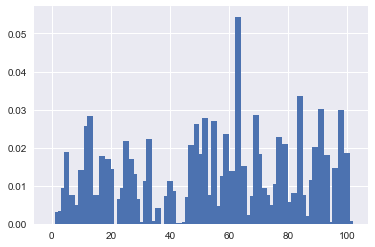

In [41]:
plt.bar(range(len(RF_vec.feature_importances_)), RF_vec.feature_importances_, 2)
#plt.yscale('symlog')
plt.show()

In [42]:
X_test1 = vec.transform(tags_test)
X_test1.shape

(3724, 102)

In [108]:
preds1 = RF_vec.predict(X_test1)
print("making predictions...")
results1 = np.argmax(preds1, axis=1)
print("writing predictions...")
util.write_predictions(results1, test_ids, 'AC_preds_1.csv')
reorder_submission('AC_preds_1.csv', "AC_results_1.csv")

making predictions...
writing predictions...
Reordered AC_preds_1.csv and wrote to AC_results_1.csv


In [248]:
# Include 2-grams
vec2 = CountVectorizer(ngram_range=(2,2))
print('Feature extraction...')
X_train2 = vec2.fit_transform(tags_train)
print(X_train2.shape)

Feature extraction...
(3086, 2183)


2183
0.9624108878807518


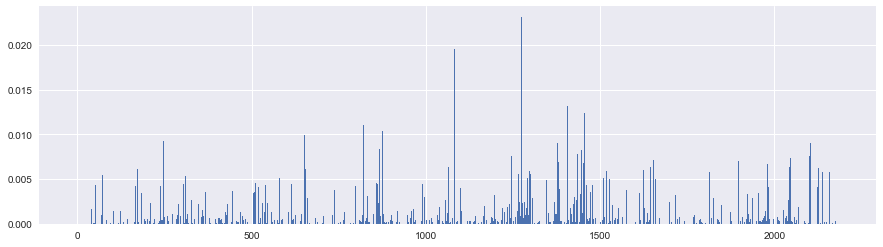

In [249]:
RF_vec2 = RandomForestClassifier(class_weight = "balanced", n_jobs = -1)
RF_vec2.fit(X_train2, y_train)
print(RF_vec2.n_features_)
print(RF_vec2.score(X_train2, y_train))
plt.figure(figsize=(15,4))
plt.bar(range(len(RF_vec2.feature_importances_)), RF_vec2.feature_importances_, 2)
plt.show()

In [251]:
imp2 = np.flip(np.argsort(RF_vec2.feature_importances_),0)
print('Most important feature: ',
      list(vec2.vocabulary_.keys())[list(vec2.vocabulary_.values()).index(imp2[0])])
print('Second most important: ',
      list(vec2.vocabulary_.keys())[list(vec2.vocabulary_.values()).index(imp2[1])])

Most important feature:  load_dll load_dll
Second most important:  get_system_directory read_section


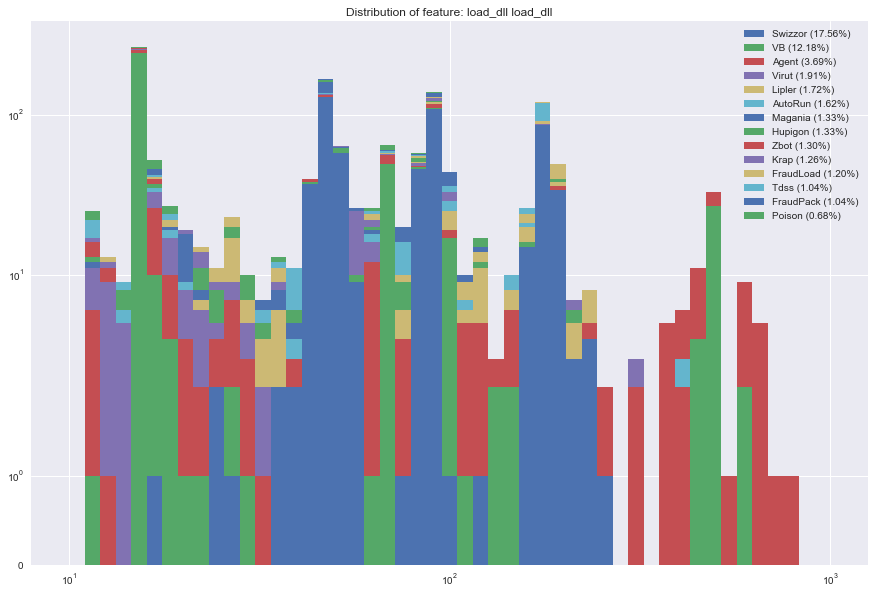

In [254]:
# Plot most important feature over histogram classes
plt.clf()
plt.figure(figsize=(15,10))
plt.rc('axes', labelsize=20)
feat_cts = []
label = []
iclass = np.flip(np.argsort(np.sum(y_train,axis=0)),0)[1:]
for i in iclass:
    feat_cts.append(X_train2[y_train[:,i]==1,imp2[0]].toarray().T[0])
    label.append('{} ({:.2f}%)'.format(util.malware_classes[i],100*np.sum(y_train[:,i])/np.sum(y_train)))
plt.hist(feat_cts, bins=np.logspace(1,3,50),histtype='barstacked')
plt.title('Distribution of feature: '+list(vec2.vocabulary_.keys())[list(vec2.vocabulary_.values()).index(imp2[0])])
plt.xscale('log')
plt.yscale('symlog')
plt.legend(label)
plt.show()

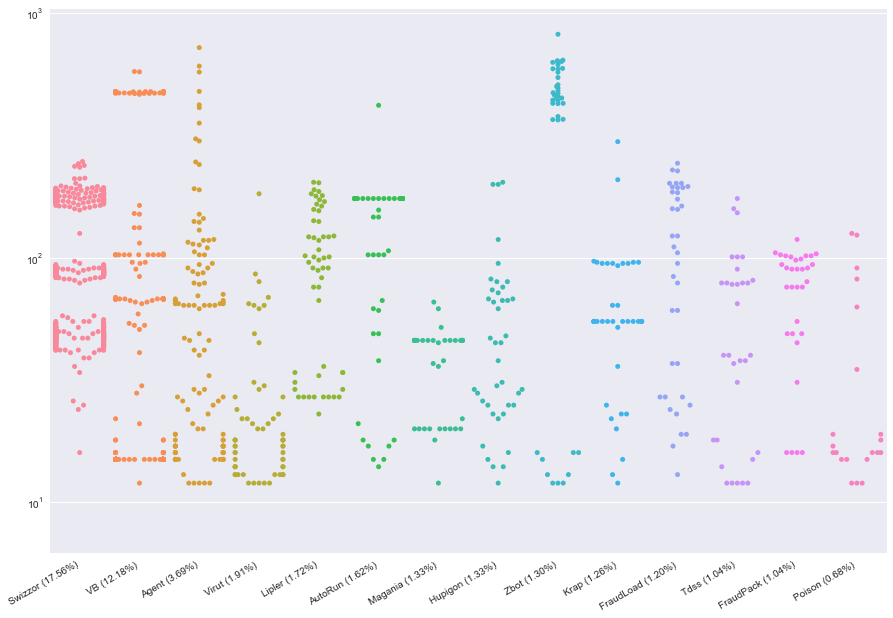

In [255]:
# Show distributions in swarmplot
plt.clf()
plt.figure(figsize=(15,10))
#sns.violinplot(data=feat_cts)
sns.swarmplot(data=feat_cts)
plt.xticks(range(len(label)),label,rotation=30,ha='right')
plt.yscale('symlog')
plt.show()

In [257]:
print('Feature extraction...')
X_test2 = vec2.transform(tags_test)
X_test2.shape

Feature extraction...


(3724, 2183)

In [258]:
preds2 = RF_vec2.predict(X_test2)
print("making predictions...")
results2 = np.argmax(preds2, axis=1)
print("writing predictions...")
util.write_predictions(results2, test_ids, 'AC_preds_2.csv')
reorder_submission('AC_preds_2.csv', "AC_results_2.csv")

making predictions...
writing predictions...
Reordered AC_preds_2.csv and wrote to AC_results_2.csv


In [121]:
vec2.vocabulary_

{'load_image': 1372,
 'load_dll': 1297,
 'open_file': 1414,
 'check_for_debugger': 28,
 'get_system_directory': 1097,
 'open_key': 1480,
 'query_value': 1691,
 'create_mutex': 307,
 'set_windows_hook': 1981,
 'create_window': 544,
 'find_window': 956,
 'enum_window': 853,
 'show_window': 2006,
 'open_process': 1561,
 'get_file_attributes': 1016,
 'create_thread': 480,
 'sleep': 2036,
 'destroy_window': 681,
 'find_file': 905,
 'com_create_instance': 53,
 'vm_protect': 2204,
 'enum_keys': 759,
 'enum_values': 829,
 'get_windows_directory': 1233,
 'com_get_class_object': 94,
 'create_process': 404,
 'kill_process': 1274,
 'thread': 2109,
 'process': 1688,
 'load_image load_dll': 1373,
 'load_dll load_dll': 1339,
 'load_dll open_file': 1342,
 'open_file check_for_debugger': 1415,
 'check_for_debugger load_dll': 45,
 'load_dll get_system_directory': 1333,
 'get_system_directory open_key': 1132,
 'open_key open_key': 1518,
 'open_key query_value': 1524,
 'query_value create_mutex': 1702,
 '

In [131]:
# Include 3-grams
vec3 = CountVectorizer(ngram_range=(1,3))
print('Feature extraction...')
X_train3 = vec3.fit_transform(tags_train1)
print(X_train3.shape)

Feature extraction...
(3086, 13188)


In [126]:
# Import Hashing Vectorizer
from sklearn.feature_extraction.text import HashingVectorizer

In [129]:
help(vec3)

Help on HashingVectorizer in module sklearn.feature_extraction.text object:

class HashingVectorizer(sklearn.base.BaseEstimator, VectorizerMixin, sklearn.base.TransformerMixin)
 |  Convert a collection of text documents to a matrix of token occurrences
 |  
 |  It turns a collection of text documents into a scipy.sparse matrix holding
 |  token occurrence counts (or binary occurrence information), possibly
 |  normalized as token frequencies if norm='l1' or projected on the euclidean
 |  unit sphere if norm='l2'.
 |  
 |  This text vectorizer implementation uses the hashing trick to find the
 |  token string name to feature integer index mapping.
 |  
 |  This strategy has several advantages:
 |  
 |  - it is very low memory scalable to large datasets as there is no need to
 |    store a vocabulary dictionary in memory
 |  
 |  - it is fast to pickle and un-pickle as it holds no state besides the
 |    constructor parameters
 |  
 |  - it can be used in a streaming (partial fit) or par

In [133]:
# Include 3-grams
hvec3 = HashingVectorizer(norm=None,ngram_range=(1,3),n_features=1000)
print('Feature extraction...')
X_train3 = hvec3.fit_transform(tags_train1)
print(X_train3.shape)

Feature extraction...
(3086, 1000)


1000
0.9627349319507453


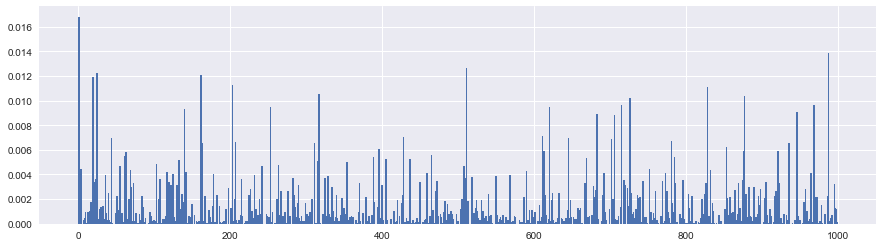

In [135]:
RF_hvec3 = RandomForestClassifier(class_weight = "balanced", n_jobs = -1)
RF_hvec3.fit(X_train3, y_train)
print(RF_hvec3.n_features_)
print(RF_hvec3.score(X_train3, y_train))
plt.figure(figsize=(15,4))
plt.bar(range(len(RF_hvec3.feature_importances_)), RF_hvec3.feature_importances_, 2)
plt.show()

In [142]:
# Explot 1-gram results further
imp1 = np.flip(np.argsort(RF_vec.feature_importances_),0)
print('Most important feature: ',list(vec.vocabulary_.keys())[list(vec.vocabulary_.values()).index(imp1[0])])

Most important feature:  load_dll


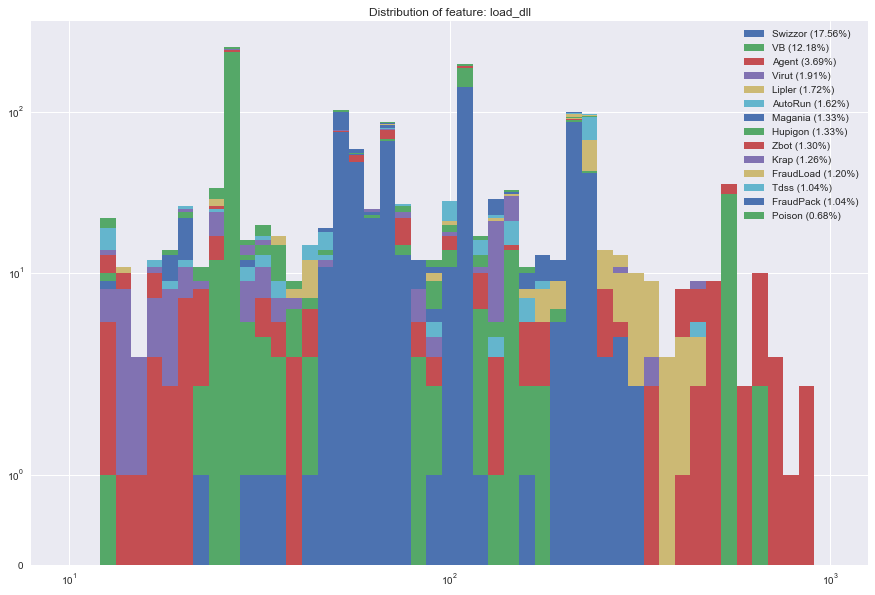

In [228]:
# Plot most important feature over histogram classes
plt.clf()
plt.figure(figsize=(15,10))
plt.rc('axes', labelsize=20)
feat_cts = []
label = []
iclass = np.flip(np.argsort(np.sum(y_train,axis=0)),0)[1:]
#for i,class0 in enumerate(util.malware_classes):
for i in iclass:
    feat_cts.append(X_train1[y_train[:,i]==1,imp1[0]].toarray().T[0])
    label.append('{} ({:.2f}%)'.format(util.malware_classes[i],100*np.sum(y_train[:,i])/np.sum(y_train)))
#    plt.hist(feat_cts,label='{} ({})'.format(class0,int(np.sum(y_train[:,i]))),
#             bins=np.logspace(1,5,50),histtype='barstacked')
plt.hist(feat_cts, #label='{} ({})'.format(class0,int(np.sum(y_train[:,i]))),
         bins=np.logspace(1,3,50),histtype='barstacked')
#         bins=np.logspace(1,5,50),histtype='barstacked')
plt.title('Distribution of feature: '+list(vec.vocabulary_.keys())[list(vec.vocabulary_.values()).index(imp1[0])])
plt.xscale('log')
plt.yscale('symlog')
plt.legend(label)
plt.show()

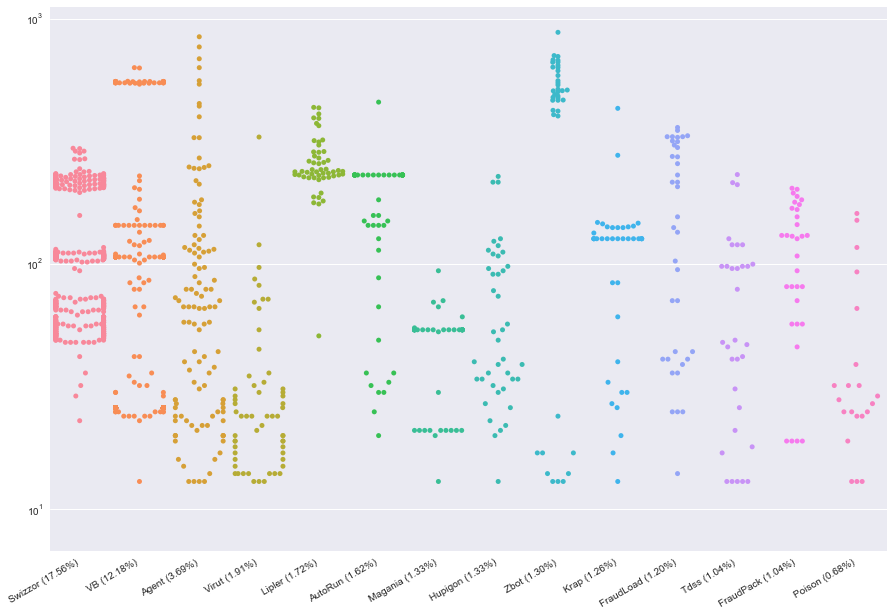

In [229]:
# Show distributions in swarmplot
plt.clf()
plt.figure(figsize=(15,10))
#sns.violinplot(data=feat_cts)
sns.swarmplot(data=feat_cts)
plt.xticks(range(len(label)),label,rotation=30,ha='right')
plt.yscale('symlog')
plt.show()

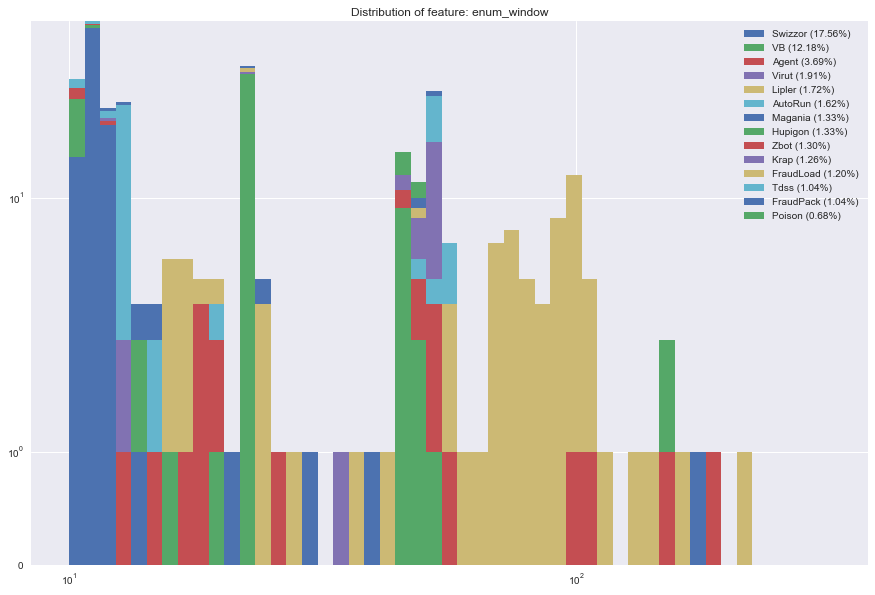

In [234]:
# Plot second most important feature over histogram classes
i0 = 1 #Feature index
feat_name = list(vec.vocabulary_.keys())[list(vec.vocabulary_.values()).index(imp1[i0])]
plt.clf()
plt.figure(figsize=(15,10))
plt.rc('axes', labelsize=20)
feat_cts = []
label = []
iclass = np.flip(np.argsort(np.sum(y_train,axis=0)),0)[1:]
for i in iclass:
    feat_cts.append(X_train1[y_train[:,i]==1,imp1[i0]].toarray().T[0])
    label.append('{} ({:.2f}%)'.format(util.malware_classes[i],100*np.sum(y_train[:,i])/np.sum(y_train)))
plt.hist(feat_cts, bins=np.logspace(1,2.5,50),histtype='barstacked')
plt.title('Distribution of feature: '+feat_name)
plt.xscale('log')
plt.yscale('symlog')
plt.legend(label)
plt.show()

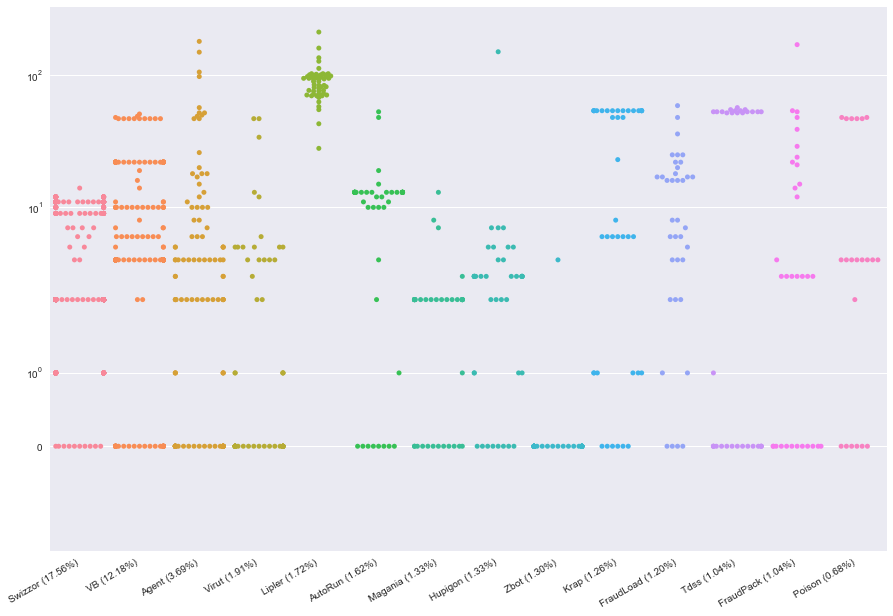

In [235]:
# Show distributions in swarmplot
plt.clf()
plt.figure(figsize=(15,10))
#sns.violinplot(data=feat_cts)
sns.swarmplot(data=feat_cts)
plt.xticks(range(len(label)),label,rotation=30,ha='right')
plt.yscale('symlog')
plt.show()

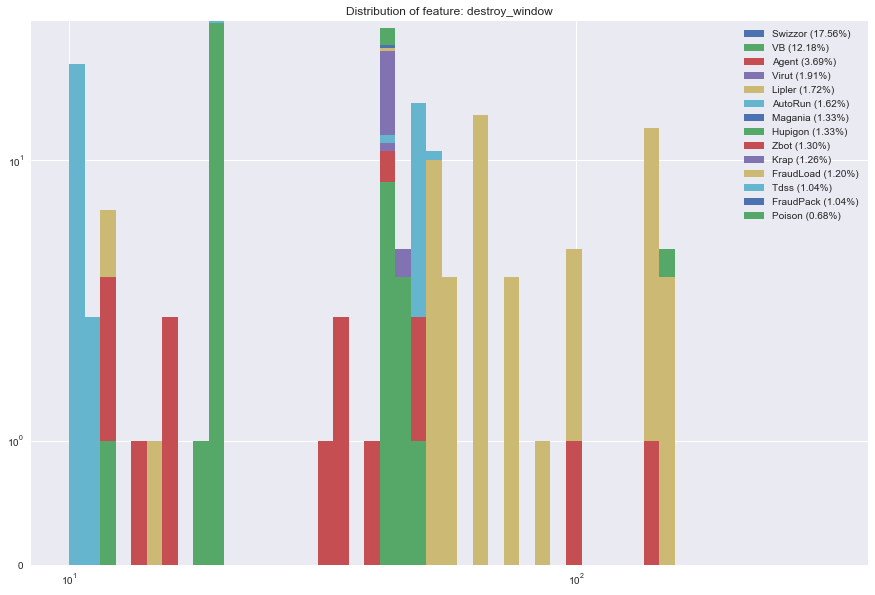

In [236]:
# Plot third most important feature over histogram classes
i0 = 2 #Feature index
feat_name = list(vec.vocabulary_.keys())[list(vec.vocabulary_.values()).index(imp1[i0])]
plt.clf()
plt.figure(figsize=(15,10))
plt.rc('axes', labelsize=20)
feat_cts = []
label = []
iclass = np.flip(np.argsort(np.sum(y_train,axis=0)),0)[1:]
for i in iclass:
    feat_cts.append(X_train1[y_train[:,i]==1,imp1[i0]].toarray().T[0])
    label.append('{} ({:.2f}%)'.format(util.malware_classes[i],100*np.sum(y_train[:,i])/np.sum(y_train)))
plt.hist(feat_cts, bins=np.logspace(1,2.5,50),histtype='barstacked')
plt.title('Distribution of feature: '+feat_name)
plt.xscale('log')
plt.yscale('symlog')
plt.legend(label)
plt.show()

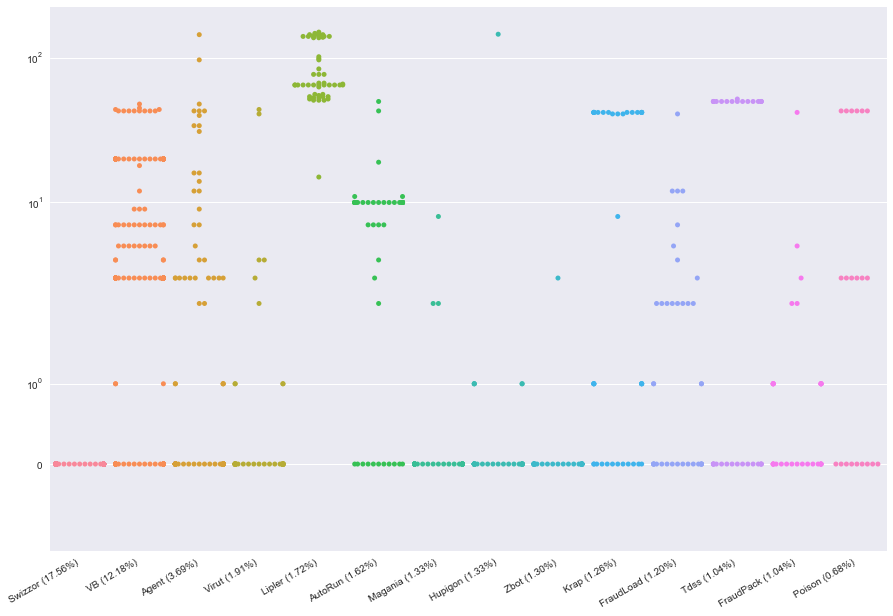

In [237]:
# Show distributions in swarmplot
plt.clf()
plt.figure(figsize=(15,10))
#sns.violinplot(data=feat_cts)
sns.swarmplot(data=feat_cts)
plt.xticks(range(len(label)),label,rotation=30,ha='right')
plt.yscale('symlog')
plt.show()

## Implement method from Canali et al

In [19]:
def get_actions(direc="data/train", global_feat_dict=None, with_args=False, 
                val_include=np.array([])):
    """
    Return a list with all "actions" (processes, with or without arguments) 
    for each file in a single string
    """
    #    fds = [] # list of feature dicts
    actions = []
    classes = []
    ids = []
    for datafile in os.listdir(direc):
        # extract id and true class (if available) from filename
        id_str,clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))
        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)
        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        # Concatenate actions
        actions_str = ''
        in_action = False
        for el in tree.iter():
            if el.tag == 'process' and not in_action:
                in_action = True
                actions_str += ('|' if actions_str != '' else '')+el.tag
                if with_args:
                    for key,val in sorted(el.attrib.items()):
                        actions_str += ' '+key+('='+val if sum(key==val_include)>0 else '')
                    #actions_str += ''.join(' {}'.format(key) for key,val in sorted(el.attrib.keys()))
            elif el.tag == 'process' and in_action:
                in_action = False
        actions.append(actions_str)
    return actions, np.array(classes), ids

In [20]:
to_sec = lambda hms: sum(float(t0)*60**i0 for i0,t0 in enumerate(hms.split(':')[::-1]))
def get_actions_num(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
      
    returns:
      a dictionary with numeric features of actions (processes) in input tree
    """
    actions_num_dict = {}
    actions_str = ''
    for el in tree.iter():
        if el.tag == 'process':
            in_action = True
            i0 = el.attrib['index']
            p0 = 'p'+i0
            dict0 = {p0+'_flag':1,
                     p0+'_parentindex':int(el.attrib['parentindex']),
                     p0+'_filesize':int(el.attrib['filesize']),
                     p0+'_starttime':to_sec(el.attrib['starttime']),
                     p0+'_dt':to_sec(el.attrib['terminationtime'])-to_sec(el.attrib['starttime'])}
            actions_num_dict.update(dict0)
    return actions_num_dict

In [21]:
def get_actions_num(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
      
    returns:
      a dictionary with numeric features of actions (processes) in input tree
    """
    c = Counter()
    actions_num_dict = {}
    actions_str = ''
    in_all_section = False
    for el in tree.iter():
        if el.tag == 'process':
            in_action = True
            i0 = el.attrib['index']
            p0 = 'p'+i0
            dict0 = {p0+'_flag':1,
                     p0+'_parentindex':int(el.attrib['parentindex']),
                     p0+'_filesize':int(el.attrib['filesize']),
                     p0+'_starttime':to_sec(el.attrib['starttime']),
                     p0+'_dt':to_sec(el.attrib['terminationtime'])-to_sec(el.attrib['starttime'])}
            actions_num_dict.update(dict0)
        elif el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            c[p0+'__'+el.tag] += 1
    actions_num_dict.update(c)
    return actions_num_dict

In [360]:
val_include = np.array(['applicationtype','executionstatus','index','parentindex','startreason',
                        'terminationreason','username'])
actions_train,t_train,train_ids = get_actions('data/train',with_args=True,
                                              val_include=val_include)

In [361]:
actions_train[100]

'process applicationtype=Win32Application executionstatus=OK filename filename_hash filesize index=1 md5 parentindex=0 pid sha1 startreason=AnalysisTarget starttime terminationreason=NormalTermination terminationtime username=Administrator|process executionstatus=OK filename filename_hash filesize index=3 md5 parentindex=0 pid sha1 startreason=SCM starttime terminationreason=Timeout terminationtime username=SYSTEM|process executionstatus=OK filename filename_hash filesize index=5 md5 parentindex=4 pid sha1 startreason=CreateProcess starttime terminationreason=Timeout terminationtime username=Administrator|process executionstatus=OK filename filename_hash filesize index=7 parentindex=5 pid startreason=CreateProcess starttime terminationreason=NormalTermination terminationtime username=Administrator|process executionstatus=OK filename filename_hash filesize index=9 md5 parentindex=8 pid sha1 startreason=CreateProcess starttime terminationreason=NormalTermination terminationtime username=

In [362]:
vec_act = CountVectorizer(actions_train, tokenizer=lambda x: x.split('|'))
print('Feature extraction...')
X_train_act = vec_act.fit_transform(actions_train)
print(X_train_act.shape)
print(np.sum(X_train_act))

Feature extraction...
(3086, 385)
7550


In [363]:
np.sum(X_train_act,axis=0)

matrix([[   5, 2780,  301,    1,    1,    1,    3,    1,    1,    1,
            1,    1,    1,    1,    1,   10,    1,    3,    1,    3,
            1,    1,    1,    1,    1,    1,    1,    1,    2,    2,
            1,    1,    1,   21,    6,    3,    4,    2,    1,    1,
           58,    1,    1,    1,    1,    1,  144,    2,    1,    2,
            2,    1,    6,    1,    8,    2,    1,    1,    5,    1,
            1,    4,    1,  144,    1,    2,   33,    1,    4,   53,
            1,    1,    1,    3,    1,    1,    7,    1,    1,    1,
            1,    1,    1,    1,    1,    1,   29,    3,    2,    4,
            1,   32,    1,    1,    1,    1,    1,    2,    1,    3,
            1,    1,    1,    1,    1,    1,    1,   11,   12,    4,
           28,    2,    1,    1,    2,    4,    1,    1,    1,    1,
            2,   12,    3,    1,    8,    1,    1,    1,    1,    1,
            1,    1,    1,    2,    9,    6,    5,    1,    1,    1,
            1,    1,    3,    5,  

In [364]:
vec_act.vocabulary_

{'process applicationtype=win32application executionerror executionstatus=windowsloadererror filename filename_hash filesize index=1 md5 parentindex=0 pid sha1 startreason=analysistarget starttime terminationreason=killedbywindowsloader terminationtime username=administrator': 0,
 'process applicationtype=win32application executionstatus=ok filename filename_hash filesize index=1 md5 parentindex=0 pid sha1 startreason=analysistarget starttime terminationreason=normaltermination terminationtime username=administrator': 1,
 'process applicationtype=win32application executionstatus=ok filename filename_hash filesize index=1 md5 parentindex=0 pid sha1 startreason=analysistarget starttime terminationreason=timeout terminationtime username=administrator': 2,
 'process executionerror executionstatus=windowsloadererror filename filename_hash filesize index=13 md5 parentindex=3 pid sha1 startreason=injectedcode starttime terminationreason=killedbywindowsloader terminationtime username=administr

In [365]:
RF_vec_act = RandomForestClassifier(class_weight = "balanced", n_jobs = -1)
RF_vec_act.fit(X_train_act, y_train)
print(RF_vec_act.n_features_)
print(RF_vec_act.score(X_train_act, y_train))
imp = np.flip(np.argsort(RF_vec_act.feature_importances_),0)
print('Most important feature: ',list(vec_act.vocabulary_.keys())[list(vec_act.vocabulary_.values()).index(imp[0])])
#plt.figure(figsize=(15,4))
#plt.bar(range(len(RF_vec2.feature_importances_)), RF_vec2.feature_importances_, 2)
#plt.show()

385
0.2731691510045366
Most important feature:  process executionstatus=ok filename filename_hash filesize index=5 md5 parentindex=1 pid sha1 startreason=createprocess starttime terminationreason=normaltermination terminationtime username=administrator


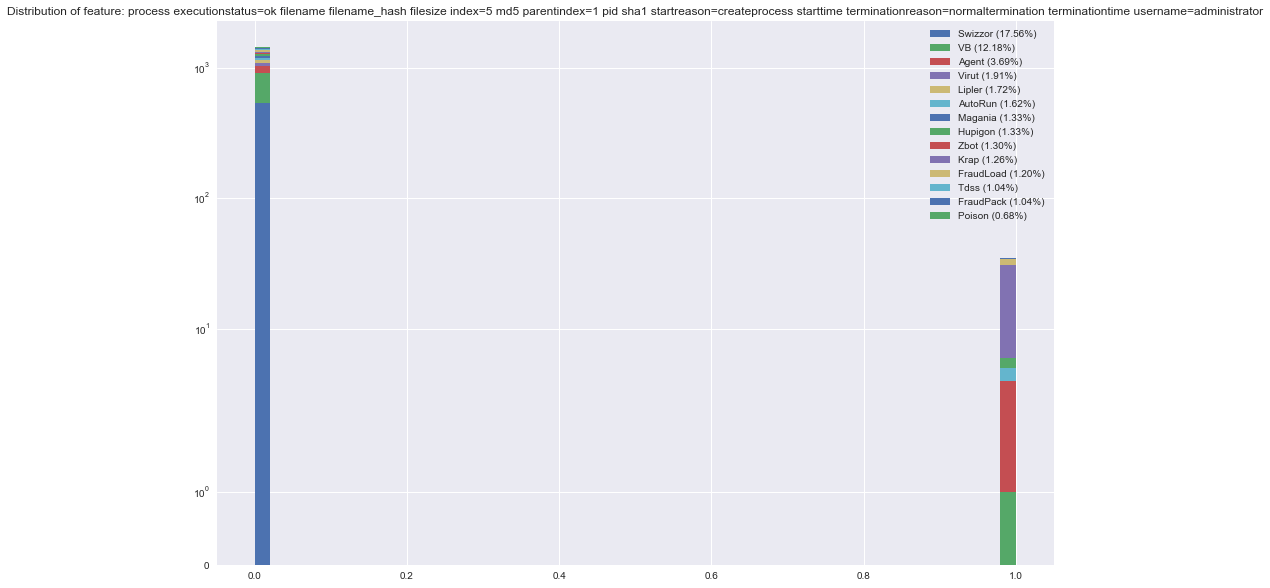

In [366]:
# Plot most important feature over histogram classes
i0 = 0 #Feature index
feat_name = list(vec_act.vocabulary_.keys())[list(vec_act.vocabulary_.values()).index(imp[i0])]
plt.clf()
plt.figure(figsize=(15,10))
plt.rc('axes', labelsize=20)
feat_cts = []
label = []
iclass = np.flip(np.argsort(np.sum(y_train,axis=0)),0)[1:]
for i in iclass:
    feat_cts.append(X_train_act[y_train[:,i]==1,imp[i0]].toarray().T[0])
    label.append('{} ({:.2f}%)'.format(util.malware_classes[i],100*np.sum(y_train[:,i])/np.sum(y_train)))
plt.hist(feat_cts, bins=50, histtype='barstacked') #bins=np.logspace(1,2.5,50))
plt.title('Distribution of feature: '+feat_name)
#plt.xscale('log')
plt.yscale('symlog')
plt.legend(label)
plt.show()

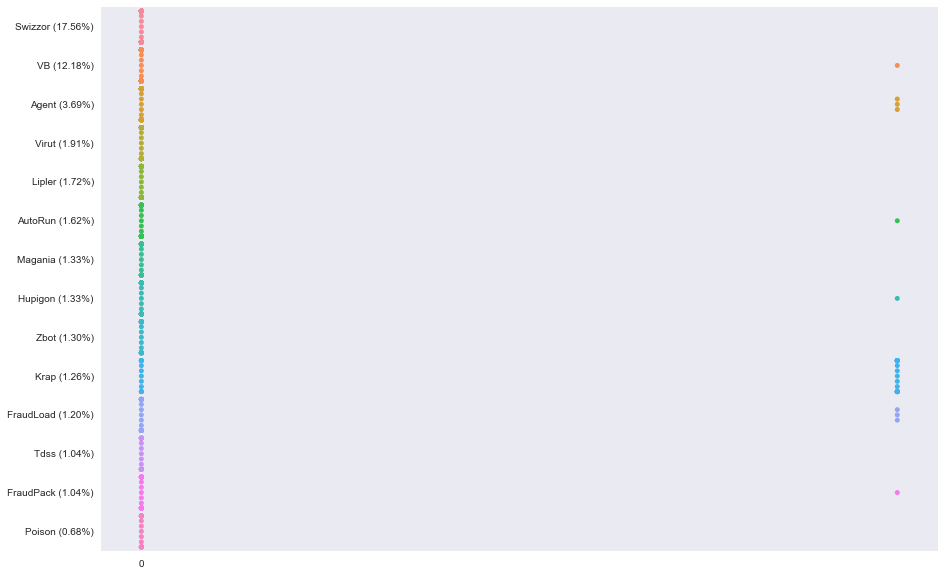

In [370]:
# Show distributions in swarmplot
plt.clf()
plt.figure(figsize=(15,10))
#sns.violinplot(data=feat_cts)
sns.swarmplot(data=feat_cts,orient='h')
plt.yticks(range(len(label)),label) #,rotation=30,ha='right')
plt.xscale('symlog')
plt.show()

In [468]:
print("extracting training features...")
X_train_act_num,global_feat_dict_act_num,t_train,train_ids = extract_feats([get_actions_num], train_dir)

extracting training features...


In [469]:
global_feat_dict_act_num

{'p10__bind_socket': 0,
 'p10__check_for_debugger': 1,
 'p10__com_create_instance': 2,
 'p10__com_get_class_object': 3,
 'p10__connect': 4,
 'p10__connect_socket': 5,
 'p10__create_directory': 6,
 'p10__create_file': 7,
 'p10__create_key': 8,
 'p10__create_mutex': 9,
 'p10__create_open_file': 10,
 'p10__create_process': 11,
 'p10__create_socket': 12,
 'p10__create_thread': 13,
 'p10__create_window': 14,
 'p10__delete_file': 15,
 'p10__delete_key': 16,
 'p10__delete_value': 17,
 'p10__destroy_window': 18,
 'p10__dump_line': 19,
 'p10__enum_keys': 20,
 'p10__enum_modules': 21,
 'p10__enum_values': 22,
 'p10__enum_window': 23,
 'p10__find_file': 24,
 'p10__find_window': 25,
 'p10__get_computer_name': 26,
 'p10__get_file_attributes': 27,
 'p10__get_host_by_name': 28,
 'p10__get_system_directory': 29,
 'p10__get_system_time': 30,
 'p10__get_username': 31,
 'p10__get_windows_directory': 32,
 'p10__impersonate_user': 33,
 'p10__kill_process': 34,
 'p10__load_dll': 35,
 'p10__load_image': 36,


2756
0.9795852235904083
Most important feature:  p1_filesize


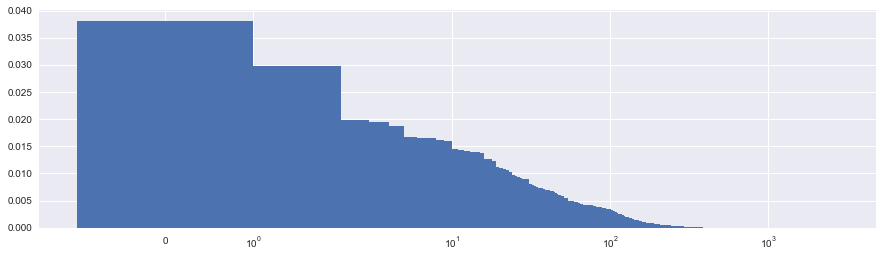

In [470]:
RF_act_num = RandomForestClassifier(class_weight = "balanced", n_jobs = -1)
RF_act_num.fit(X_train_act_num, y_train)
print(RF_act_num.n_features_)
print(RF_act_num.score(X_train_act_num, y_train))
imp = np.flip(np.argsort(RF_act_num.feature_importances_),0)
print('Most important feature: ',list(global_feat_dict_act_num.keys())[list(global_feat_dict_act_num.values()).index(imp[0])])
plt.figure(figsize=(15,4))
plt.bar(range(len(RF_act_num.feature_importances_)), np.sort(RF_act_num.feature_importances_)[::-1], 2)
plt.xscale('symlog')
plt.show()

In [471]:
['{:20s}{}'.format(list(global_feat_dict_act_num.keys())[list(global_feat_dict_act_num.values()).index(i)],RF_act_num.feature_importances_[i]) for i in imp]

['p1_filesize         0.038149154875302196',
 'p1_dt               0.02987991110612529',
 'p1__open_key        0.01979371993975785',
 'p1_starttime        0.019464273036117828',
 'p1__vm_protect      0.01876583316769655',
 'p1__load_dll        0.01665209693512986',
 'p1__enum_window     0.016576437403939093',
 'p1__open_file       0.01655014236761122',
 'p1__create_process  0.016215222734875894',
 'p1__get_system_directory0.01606622516676996',
 'p1__query_value     0.014514244844713814',
 'p1__sleep           0.014232783272963626',
 'p1__create_mutex    0.014187138849567852',
 'p1__create_file     0.013972313271652409',
 'p1__get_file_attributes0.013931527337799201',
 'p1__create_window   0.01373975123409379',
 'p1__destroy_window  0.012663021815383296',
 'p1__get_windows_directory0.012579650572869042',
 'p1__find_file       0.01222344078315694',
 'p1__create_thread   0.011139992531519169',
 'p1__show_window     0.010933115129347169',
 'p1__set_value       0.010754959897319094',
 'p1__

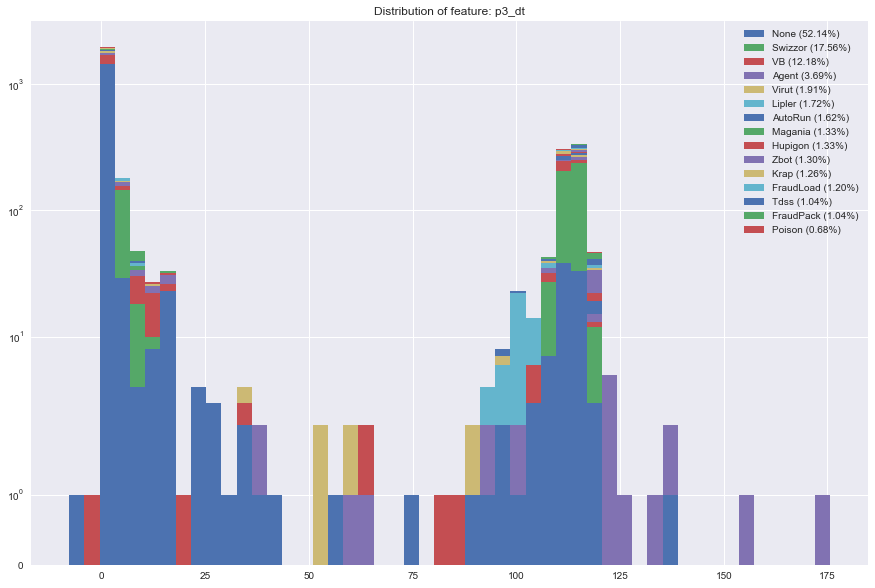

In [420]:
# Plot most important feature over histogram classes
i0 = 5 #Feature index
feat_name = list(global_feat_dict_act_num.keys())[list(global_feat_dict_act_num.values()).index(imp[i0])]
plt.clf()
plt.figure(figsize=(15,10))
plt.rc('axes', labelsize=20)
feat_cts = []
label = []
iclass = np.flip(np.argsort(np.sum(y_train,axis=0)),0)[0:]
for i in iclass:
    feat_cts.append(X_train_act_num[y_train[:,i]==1,imp[i0]].toarray().T[0])
    label.append('{} ({:.2f}%)'.format(util.malware_classes[i],100*np.sum(y_train[:,i])/np.sum(y_train)))
plt.hist(feat_cts, bins=50, histtype='barstacked') #bins=np.logspace(1,2.5,50))
plt.title('Distribution of feature: '+feat_name)
#plt.xscale('log')
plt.yscale('symlog')
plt.legend(label)
plt.show()

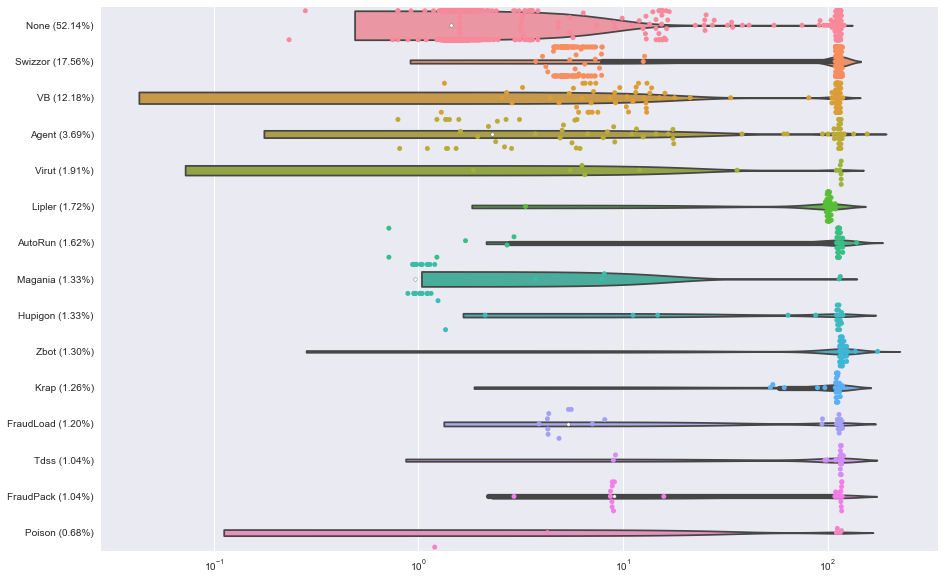

In [423]:
# Show distributions in swarmplot
plt.clf()
plt.figure(figsize=(15,10))
sns.violinplot(data=feat_cts,orient='h')
sns.swarmplot(data=feat_cts,orient='h')
plt.yticks(range(len(label)),label) #,rotation=30,ha='right')
plt.xscale('log')
plt.show()

In [472]:
print("extracting test features...")
X_test_act_num,_,t_ignore,test_ids = extract_feats([get_actions_num], test_dir, global_feat_dict=global_feat_dict_act_num)

extracting test features...


In [411]:
preds_act_num = RF_act_num.predict(X_test_act_num)
print("making predictions...")
results_act_num = np.argmax(preds_act_num, axis=1)
print("writing predictions...")
util.write_predictions(results_act_num, test_ids, 'AC_preds_3.csv')
reorder_submission('AC_preds_3.csv', 'AC_results_3.csv')

making predictions...
writing predictions...
Reordered AC_preds_3.csv and wrote to AC_results_3.csv


In [29]:
# Scale features
from sklearn.preprocessing import scale

In [426]:
X_train_act_num_scl = scale(X_train_act_num,with_mean=False)
X_test_act_num_scl = scale(X_test_act_num,with_mean=False)

430
0.9698639014906028
Most important feature:  p1_filesize


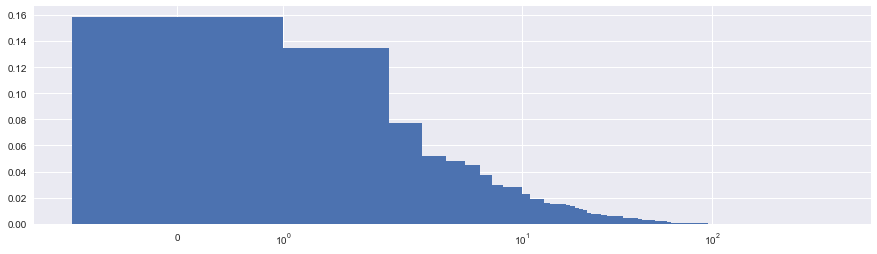

In [427]:
RF_act_num_scl = RandomForestClassifier(class_weight = "balanced", n_jobs = -1)
RF_act_num_scl.fit(X_train_act_num_scl, y_train)
print(RF_act_num_scl.n_features_)
print(RF_act_num_scl.score(X_train_act_num_scl, y_train))
imp = np.flip(np.argsort(RF_act_num_scl.feature_importances_),0)
print('Most important feature: ',list(global_feat_dict_act_num.keys())[list(global_feat_dict_act_num.values()).index(imp[0])])
plt.figure(figsize=(15,4))
plt.bar(range(len(RF_act_num_scl.feature_importances_)), np.sort(RF_act_num_scl.feature_importances_)[::-1], 2)
plt.xscale('symlog')
plt.show()

In [428]:
preds_act_num_scl = RF_act_num_scl.predict(X_test_act_num_scl)
print("making predictions...")
results_act_num_scl = np.argmax(preds_act_num_scl, axis=1)
print("writing predictions...")
util.write_predictions(results_act_num_scl, test_ids, 'AC_preds_4.csv')
reorder_submission('AC_preds_4.csv', 'AC_results_4.csv')

making predictions...
writing predictions...
Reordered AC_preds_4.csv and wrote to AC_results_4.csv


In [474]:
# Correct scaling
i = X_train_act_num.shape[0]
X_scl = scale(sparse.vstack([X_train_act_num,X_test_act_num]),with_mean=False)
X_train_act_num_scl = X_scl[:i,:]
X_test_act_num_scl  = X_scl[i:,:]
del X_scl
print(X_train_act_num_scl.shape)
print(X_test_act_num_scl.shape)

(3086, 2756)
(3724, 2756)


2756
0.9763447828904731
Most important feature:  p1__load_dll


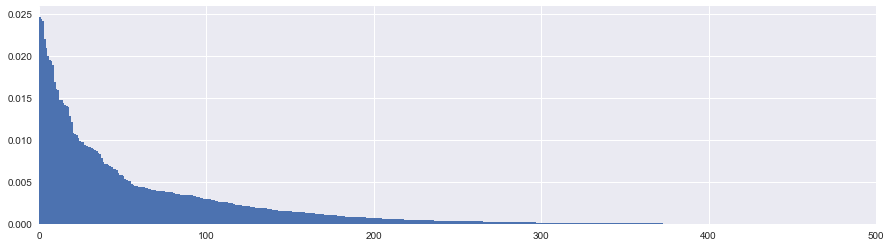

In [476]:
RF_act_num_scl = RandomForestClassifier(class_weight = "balanced", n_jobs = -1)
RF_act_num_scl.fit(X_train_act_num_scl, y_train)
print(RF_act_num_scl.n_features_)
print(RF_act_num_scl.score(X_train_act_num_scl, y_train))
imp = np.flip(np.argsort(RF_act_num_scl.feature_importances_),0)
print('Most important feature: ',list(global_feat_dict_act_num.keys())[list(global_feat_dict_act_num.values()).index(imp[0])])
plt.clf()
plt.figure(figsize=(15,4))
plt.bar(range(len(RF_act_num_scl.feature_importances_)), np.sort(RF_act_num_scl.feature_importances_)[::-1], 2)
plt.xlim((0,500))
#plt.yscale('log')
plt.show()

In [477]:
preds_act_num_scl = RF_act_num_scl.predict(X_test_act_num_scl)
print("making predictions...")
results_act_num_scl = np.argmax(preds_act_num_scl, axis=1)
print("writing predictions...")
util.write_predictions(results_act_num_scl, test_ids, 'AC_preds_6.csv')
reorder_submission('AC_preds_6.csv', 'AC_results_6.csv')

making predictions...
writing predictions...
Reordered AC_preds_6.csv and wrote to AC_results_6.csv


In [452]:
['{:20s}{}'.format(list(global_feat_dict_act_num.keys())[list(global_feat_dict_act_num.values()).index(i)],RF_act_num_scl.feature_importances_[i]) for i in imp]

['p1_filesize         0.15549672796597167',
 'p1_dt               0.11505294715213683',
 'p1_starttime        0.09116627487836233',
 'p2_dt               0.050338691326434204',
 'p2_filesize         0.046117333709656996',
 'p2_starttime        0.04239797107419035',
 'p3_dt               0.03762683590264327',
 'p3_starttime        0.034905800483750124',
 'p3_filesize         0.028603840718161987',
 'p4_dt               0.027252597272561917',
 'p5_filesize         0.023533195379123645',
 'p5_starttime        0.02313313710310844',
 'p4_starttime        0.022475614442183996',
 'p3_parentindex      0.021864293520342314',
 'p4_parentindex      0.015968018850980044',
 'p2_parentindex      0.015902698791280808',
 'p4_filesize         0.01542986405590921',
 'p6_starttime        0.015324963413806816',
 'p7_dt               0.011392295501246142',
 'p5_dt               0.009888408875845897',
 'p15_parentindex     0.009740035411760831',
 'p6_flag             0.009106468273048415',
 'p15_starttime  

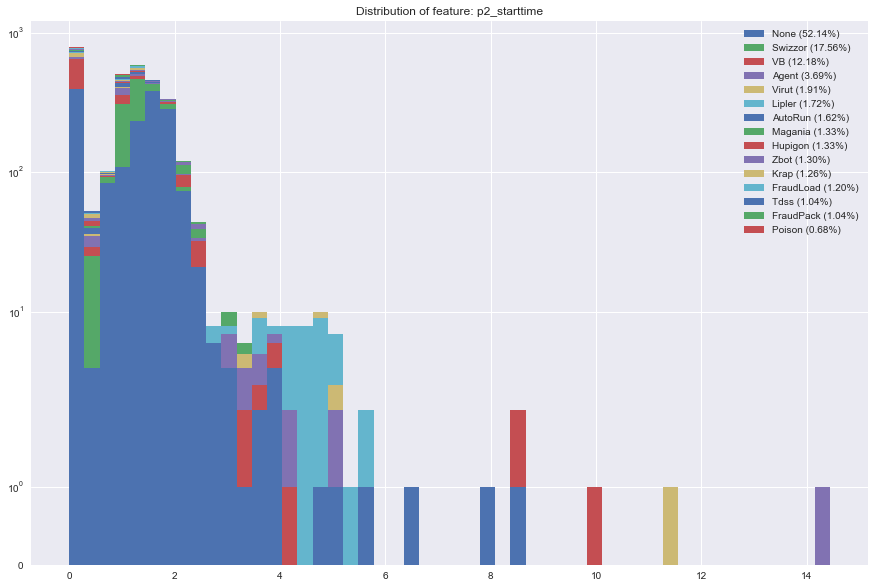

In [465]:
# Plot most important feature over histogram classes
i0 = 5 # Feature index
feat_name = list(global_feat_dict_act_num.keys())[list(global_feat_dict_act_num.values()).index(imp[i0])]
plt.clf()
plt.figure(figsize=(15,10))
plt.rc('axes', labelsize=20)
feat_cts = []
label = []
iclass = np.flip(np.argsort(np.sum(y_train,axis=0)),0)[0:]
for i in iclass:
    feat_cts.append(X_train_act_num_scl[y_train[:,i]==1,imp[i0]].toarray().T[0])
    label.append('{} ({:.2f}%)'.format(util.malware_classes[i],100*np.sum(y_train[:,i])/np.sum(y_train)))
plt.hist(feat_cts, bins=50, histtype='barstacked') #bins=np.logspace(1,2.5,50))
plt.title('Distribution of feature: '+feat_name)
#plt.xscale('log')
plt.yscale('symlog')
plt.legend(label)
plt.show()

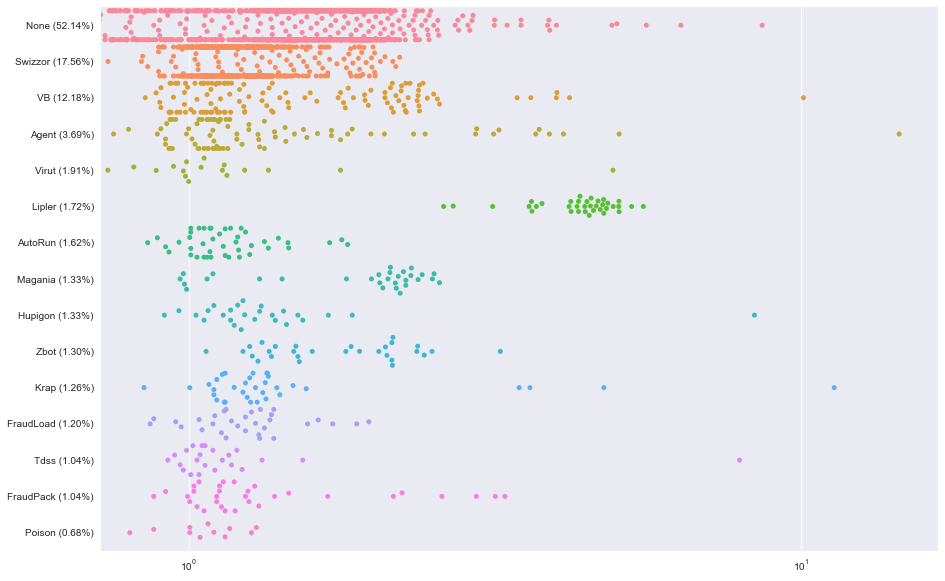

In [466]:
# Show distributions in swarmplot
plt.clf()
plt.figure(figsize=(15,10))
#sns.violinplot(data=feat_cts,orient='h')
sns.swarmplot(data=feat_cts,orient='h')
plt.yticks(range(len(label)),label) #,rotation=30,ha='right')
plt.xscale('log')
plt.show()

## 4-gram implementation

In [166]:
# Include 4-grams
vec4 = CountVectorizer(ngram_range=(1,4))
print('Feature extraction...')
X_train4_all = vec4.fit_transform(tags_train)
print(X_train4_all.shape)

Feature extraction...
(3086, 36964)


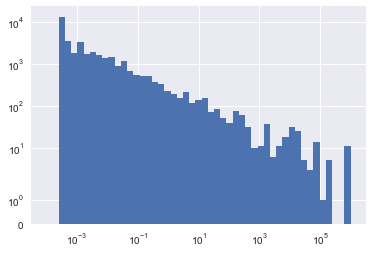

In [55]:
# Discriminate by feature variance
var4 = np.var(X_train4.toarray(),axis=0)
plt.hist(var4,bins=np.logspace(-4,6,50))
plt.xscale('log')
plt.yscale('symlog')
plt.show()

In [83]:
ivar4 = var4 > 1e3
print(np.sum(ivar4))

ivar4 = np.argsort(var4)[:np.sum(var4 < 1e3)-1:-1]
ivar4.shape

185


(185,)

In [22]:
# Create new dictionary
def get_dict_varthresh(X,dict_old,varthresh=0):
    """
    Get new feature matrix and dictionary
    with features above variance varthresh
    """
    var = np.var(X.toarray(),axis=0)
    ivar = np.argsort(var)[:np.sum(var < varthresh)-1:-1]
    X_varthresh = X[:,ivar]
    dict_varthresh = {list(dict_old.keys())[list(dict_old.values()).index(ivar0)]:i for i,ivar0 in enumerate(ivar)}
    return X_varthresh, dict_varthresh

In [117]:
X_train4_var, dict4_var = get_dict_varthresh(X_train4,vec4.vocabulary_,varthresh=1e1)
print('Feature extraction with new dictionary...')
vec4_var = CountVectorizer(ngram_range=(1,4),vocabulary=dict4_var)
X_train4_var = vec4_var.fit_transform(tags_train)
print(X_train4_var.shape)

Feature extraction with new dictionary...
(3086, 851)


851
0.9604666234607907


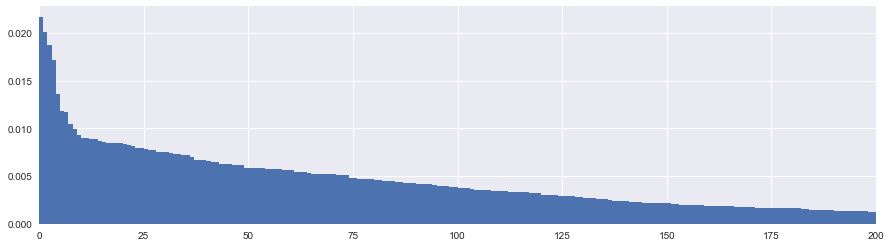

In [131]:
RF_vec4_var = RandomForestClassifier(class_weight = "balanced", n_jobs = -1)
RF_vec4_var.fit(X_train4_var, y_train)
print(RF_vec4_var.n_features_)
print(RF_vec4_var.score(X_train4_var, y_train))
plt.figure(figsize=(15,4))
plt.bar(range(len(RF_vec4_var.feature_importances_)), np.sort(RF_vec4_var.feature_importances_)[::-1], 2)
plt.xlim(0,200)
plt.show()

In [124]:
print('Feature extraction...')
X_test4_var = vec4_var.transform(tags_test)
print(X_test4_var.shape)
preds4_var = RF_vec4_var.predict(X_test4_var)
print("making predictions...")
results4_var = np.argmax(preds4_var, axis=1)
print("writing predictions...")
util.write_predictions(results4_var, test_ids, 'AC_preds_7.csv')
reorder_submission('AC_preds_7.csv', "AC_results_7.csv")

Feature extraction...
(3724, 851)
making predictions...
writing predictions...
Reordered AC_preds_7.csv and wrote to AC_results_7.csv


## 4-grams with HashingVectorizer

In [23]:
# Import Hashing Vectorizer
from sklearn.feature_extraction.text import HashingVectorizer

In [135]:
hvec4 = HashingVectorizer(norm=None,ngram_range=(4,4),n_features=1000)
print('Feature extraction...')
X_train4 = hvec4.fit_transform(tags_train)
print(X_train4.shape)

Feature extraction...
(3086, 1000)


1000
0.9792611795204148


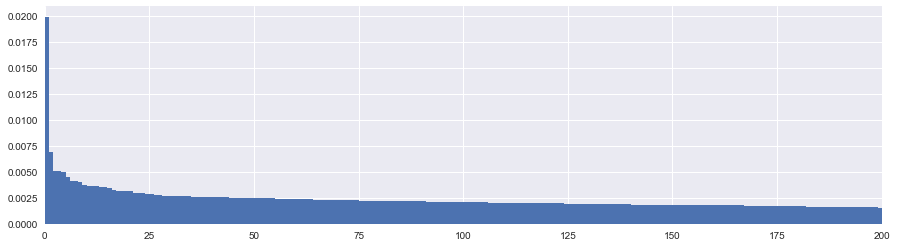

In [142]:
RF_hvec4 = RandomForestClassifier(class_weight = "balanced", n_jobs = -1,
                                 n_estimators=1000, max_features='log2')
RF_hvec4.fit(X_train4, y_train)
print(RF_hvec4.n_features_)
print(RF_hvec4.score(X_train4, y_train))
plt.figure(figsize=(15,4))
plt.bar(range(len(RF_hvec4.feature_importances_)), np.sort(RF_hvec4.feature_importances_)[::-1], 2)
plt.xlim(0,200)
plt.show()

## RandomForestClassifier hyperparameter tuning

851
0.9782890473104342
Most important features:  load_dll


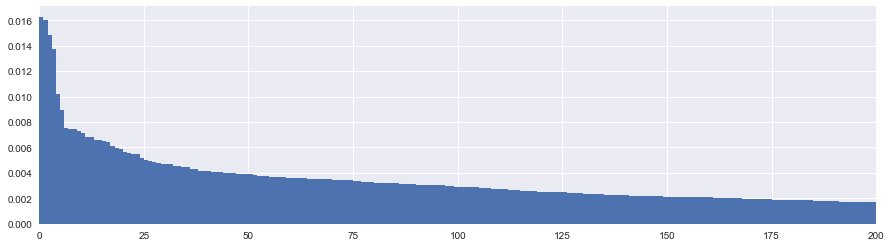

In [152]:
RF_vec4_var = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                    n_estimators=1000, max_features='log2')
RF_vec4_var.fit(X_train4_var, y_train)
print(RF_vec4_var.n_features_)
print(RF_vec4_var.score(X_train4_var, y_train))
imp = np.argsort(RF_vec4_var.feature_importances_)[::-1]
print('Most important features: ',list(vec4_var.vocabulary_.keys())[list(vec4_var.vocabulary_.values()).index(imp[0])])
plt.clf()
plt.figure(figsize=(15,4))
plt.bar(range(len(RF_vec4_var.feature_importances_)), np.sort(RF_vec4_var.feature_importances_)[::-1], 2)
plt.xlim(0,200)
plt.show()

In [154]:
['{:20s}{}'.format(list(vec4_var.vocabulary_.keys())[list(vec4_var.vocabulary_.values()).index(i)],RF_vec4_var.feature_importances_[i]) for i in imp[0:10]]

['load_dll            0.016276786821793884',
 'load_dll load_dll   0.015991523477363743',
 'load_dll load_dll load_dll0.014866661757076429',
 'load_dll load_dll load_dll load_dll0.013732781088840615',
 'create_mutex        0.010213535313679585',
 'sleep               0.008968571257965059',
 'open_file           0.0075477549860264006',
 'thread              0.007483652421169842',
 'create_thread       0.007422968040097944',
 'create_open_file    0.007330981448335554']

## Create holdout set

In [24]:
from sklearn.model_selection import train_test_split

In [167]:
X_train4, X_holdout4, y_train4, y_holdout4 = train_test_split(X_train4_all, y_train, test_size=0.2,
                                                              stratify=y_train, random_state=20)

36964
0.9789303079416531
Most important feature:  load_dll load_dll


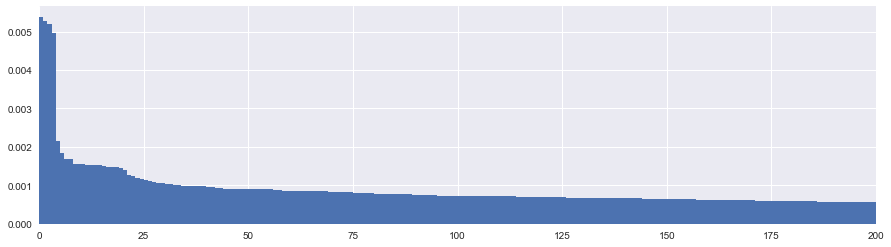

In [188]:
RF_vec4 = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                 n_estimators=1000, max_features='sqrt')
RF_vec4.fit(X_train4, y_train4)
print(RF_vec4.n_features_)
print(RF_vec4.score(X_train4, y_train4))
imp = np.argsort(RF_vec4.feature_importances_)[::-1]
print('Most important feature: ',list(vec4.vocabulary_.keys())[list(vec4.vocabulary_.values()).index(imp[0])])
plt.clf()
plt.figure(figsize=(15,4))
xlim = 200
plt.bar(range(xlim), RF_vec4.feature_importances_[imp[0:xlim]], 2)
plt.xlim(0,xlim)
plt.show()

In [222]:
classes = np.array(util.malware_classes)
n_classes = len(classes)
iclasses = np.arange(n_classes)
for i in range(n_classes):
    print('{:10s}{:5d}   {:.3f}'.format(classes[i], int(np.sum(y_holdout4[:,i])),
                                     RF_vec4.score(X_holdout4[y_holdout4[:,i]==1,:], 
                                                   y_holdout4[y_holdout4[:,i]==1,:])))

Agent        23   0.130
AutoRun      10   0.500
FraudLoad     8   0.750
FraudPack     6   1.000
Hupigon       8   0.500
Krap          8   0.750
Lipler       11   0.909
Magania       8   0.875
None        322   0.891
Poison        4   0.000
Swizzor     109   0.991
Tdss          6   0.333
VB           75   0.853
Virut        12   0.250
Zbot          8   1.000


In [295]:
classes = np.array(util.malware_classes)
n_classes = len(classes)
iclasses = np.arange(n_classes)
ih = np.arange(X_holdout4.shape[0])
for i in range(n_classes-1):
    # Fit classifier on current classes
    RF_vec4_ = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                      n_estimators=1000, max_features='sqrt')
    y_train4_ = y_train4[:,iclasses]
    y_holdout4_ = y_holdout4[:,iclasses]
    ix = np.sum(y_train4_,axis=1) > 0
    RF_vec4_.fit(X_train4[ix,:], y_train4_[ix,:])
    print(i+1,') Scores: Train ',RF_vec4_.score(X_train4[ix,:], y_train4_[ix,:]),
          ', Holdout ',RF_vec4_.score(X_holdout4[ih,:], y_holdout4_[ih,:]))
    # Find smallest class with largest score  
    score = [RF_vec4_.score(X_holdout4[ih[y_holdout4[ih,j]==1],:],
                            y_holdout4_[ih[y_holdout4[ih,j]==1],:]) for j in iclasses]
    imax = [np.argmax(score)]
    if len(imax) > 1:
        y_holdout4_ = y_holdout4[:,iclasses[imax]]
        imax = imax[np.argmin(np.sum(y_holdout4_[ih,:],axis=0))]
    else: imax = imax[0]
    print('     Best class: {:10s} ({:3d} elements). Score: {:.3f}'.format(classes[imax],
        int(np.sum(y_holdout4[ih,iclasses[imax]],axis=0)), score[imax]))
    # Make predictions for best class
    preds4_ = RF_vec4_.predict(X_holdout4[ih,:])
    results4_ = np.argmax(preds4_, axis=1)
    if i < n_classes-2:
        # Take out best class
        ih = ih[results4_ != imax]
        classes = np.delete(classes, imax)
        iclasses = np.delete(iclasses, imax)

1 ) Scores: Train  0.9789303079416531 , Holdout  0.8511326860841424
     Best class: FraudPack  (  6 elements). Score: 1.000
2 ) Scores: Train  0.9787059787059788 , Holdout  0.851063829787234
     Best class: Zbot       (  8 elements). Score: 1.000
3 ) Scores: Train  0.979253112033195 , Holdout  0.8552412645590682
     Best class: Swizzor    (109 elements). Score: 0.991
4 ) Scores: Train  0.9747091552857865 , Holdout  0.8275862068965517
     Best class: None       (319 elements). Score: 0.915
5 ) Scores: Train  0.9739130434782609 , Holdout  0.732620320855615
     Best class: VB         ( 73 elements). Score: 0.918
6 ) Scores: Train  0.9717223650385605 , Holdout  0.6371681415929203
     Best class: Lipler     ( 11 elements). Score: 0.909
7 ) Scores: Train  0.968299711815562 , Holdout  0.6213592233009708
     Best class: FraudLoad  (  8 elements). Score: 0.875
8 ) Scores: Train  0.9654088050314465 , Holdout  0.5729166666666666
     Best class: Magania    (  8 elements). Score: 0.875
9 ) 

## Cross-validation scoring

In [25]:
from sklearn.model_selection import cross_val_score

In [301]:
RF_vec4_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                    n_estimators=1000, max_features='sqrt')
cv_scores = cross_val_score(RF_vec4_cv, X_train4_all, y_train, cv=5)
print(cv_scores)
print(np.mean(cv_scores))

[0.8592233  0.82009724 0.86223663 0.85737439 0.86385737]
0.8525577882330726


In [302]:
RF_vec4_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                    n_estimators=100, max_features='sqrt')
cv_scores = cross_val_score(RF_vec4_cv, X_train4_all, y_train, cv=5)
print(cv_scores)
print(np.mean(cv_scores))

[0.85275081 0.82171799 0.86385737 0.85899514 0.86061588]
0.8515874389597856


In [303]:
RF_vec4_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                    n_estimators=10, max_features='sqrt')
cv_scores = cross_val_score(RF_vec4_cv, X_train4_all, y_train, cv=5)
print(cv_scores)
print(np.mean(cv_scores))

[0.83333333 0.81523501 0.85737439 0.84927066 0.84764992]
0.8405726634251757


## Sequential predictions by class

In [297]:
print('Feature extraction...')
X_test4 = vec4.transform(tags_test)
X_test4.shape

Feature extraction...


(3724, 36964)

In [304]:
# Initialize array of results
results4 = np.full(X_test4.shape[0],-1)
classes = np.array(util.malware_classes)
n_classes = len(classes)
iclasses = np.arange(n_classes)
ih = np.arange(X_test4.shape[0])
for i in range(n_classes-1):
    # Fit classifier on current classes
    RF_vec4_ = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                      n_estimators=1000, max_features='sqrt')
    y_train_ = y_train[:,iclasses]
    ix = np.sum(y_train_,axis=1) > 0
    RF_vec4_.fit(X_train4_all[ix,:], y_train_[ix,:])
    print(i+1,') Scores: Train ',RF_vec4_.score(X_train4_all[ix,:], y_train_[ix,:]))
    # Find smallest class with largest score  
    score = [RF_vec4_.score(X_train4_all[y_train[:,j]==1,:],
                            y_train_[y_train[:,j]==1,:]) for j in iclasses]
    imax = [np.argmax(score)]
    if len(imax) > 1:
        y_train_ = y_train[:,iclasses[imax]]
        imax = imax[np.argmin(np.sum(y_train_,axis=0))]
    else: imax = imax[0]
    print('     Best class: {:10s} ({:3d} elements). Score: {:.3f}'.format(classes[imax],
        int(np.sum(y_train[:,iclasses[imax]],axis=0)), score[imax]))
    # Make predictions for best class
    preds4_ = RF_vec4_.predict(X_test4[ih,:])
    results4_ = np.argmax(preds4_, axis=1)
    if i < n_classes-2:
        results4[ih[results4_ == imax]] = iclasses[imax]
        # Take out best class
        ih = ih[results4_ != imax]
        classes = np.delete(classes, imax)
        iclasses = np.delete(iclasses, imax)
    else:
        results4[ih] = iclasses[results4_]

1 ) Scores: Train  0.9792611795204148
     Best class: AutoRun    ( 50 elements). Score: 1.000
2 ) Scores: Train  0.9818840579710145
     Best class: FraudLoad  ( 37 elements). Score: 1.000
3 ) Scores: Train  0.9813271090363455
     Best class: FraudPack  ( 32 elements). Score: 1.000
4 ) Scores: Train  0.9811257162116616
     Best class: Lipler     ( 53 elements). Score: 1.000
5 ) Scores: Train  0.9807824296499656
     Best class: Magania    ( 41 elements). Score: 1.000
6 ) Scores: Train  0.981204316045945
     Best class: Swizzor    (542 elements). Score: 1.000
7 ) Scores: Train  0.9768339768339769
     Best class: Virut      ( 59 elements). Score: 1.000
8 ) Scores: Train  0.977112676056338
     Best class: Zbot       ( 40 elements). Score: 1.000
9 ) Scores: Train  0.978494623655914
     Best class: VB         (376 elements). Score: 0.997
10 ) Scores: Train  0.9752155172413793
     Best class: Agent      (114 elements). Score: 0.991
11 ) Scores: Train  0.9764638346727899
     Best cla

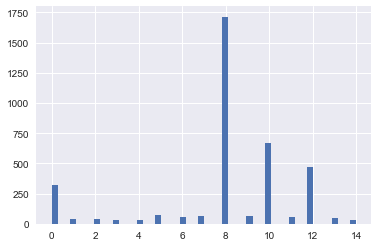

In [307]:
plt.hist(results4,bins=50)
plt.show()

In [308]:
print("writing predictions...")
util.write_predictions(results4, test_ids, 'AC_preds_8.csv')
reorder_submission('AC_preds_8.csv', "AC_results_8.csv")

writing predictions...
Reordered AC_preds_8.csv and wrote to AC_results_8.csv


## Class Scoring function for Cross-validation

In [26]:
def class_scorer(estimator, X, y):
    """
    Return index of smallest class with best score
    """
    n_classes = y.shape[1]
    score = np.zeros(n_classes)
    for i in range(n_classes):
        ix = (y[:,i] == 1)
        score[i] = estimator.score(X[ix,:],y[ix,:])
    print('      Mean class score: {:.3f}'.format(np.mean(score)))
    imax = [np.argmax(score)]
    if len(imax) > 1:
        imax = imax[np.argmin(np.sum(y[:,iclasses[imax]],axis=0))]
    else: imax = imax[0]
    return imax

In [327]:
RF_vec4_ = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                  n_estimators=1000, max_features='sqrt')
RF_vec4_.fit(X_train4_all, y_train)
score = class_scorer(RF_vec4_,X_train4_all,y_train)
score

Mean class score: 0.973


1

In [330]:
RF_vec4_cv_ = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                     n_estimators=100, max_features='sqrt')
cv_scores = cross_val_score(RF_vec4_cv_, X_train4_all, y_train, cv=5,
                            scoring=class_scorer)
print(cv_scores)

      Mean class score: 0.609
      Mean class score: 0.653
      Mean class score: 0.696
      Mean class score: 0.627
      Mean class score: 0.636
[ 6  3  3 10 14]


In [342]:
# Sequential predictions with cross-validated class scores (10 estimators)
results4 = np.full(X_test4.shape[0],-1)
classes = np.array(util.malware_classes)
n_classes = len(classes)
iclasses = np.arange(n_classes)
ih = np.arange(X_test4.shape[0])
for i in range(n_classes-1):
    print(i+1,')')
    # Fit classifier on current classes
    RF_vec4_ = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                      n_estimators=10, max_features='sqrt')
    y_train_ = y_train[:,iclasses]
    ix = np.sum(y_train_,axis=1) > 0
    cv_scores_ = cross_val_score(RF_vec4_cv_, X_train4_all[ix,:], y_train_[ix,:], 
                                 cv=5, scoring=class_scorer)
    print('     ',cv_scores_)
    # Find smallest class with largest score
    class_cts = np.bincount(cv_scores_)
    imax = (class_cts == np.max(class_cts)).nonzero()[0]
    if len(imax) > 1:
        y_train_ = y_train[:,iclasses[imax]]
        imax = imax[np.argmin(np.sum(y_train_,axis=0))]
    else: imax = imax[0]
    print('     Best class: {:10s} ({:3d} elements)'.format(classes[imax],
        int(np.sum(y_train[:,iclasses[imax]],axis=0))))
    # Make predictions for best class
    RF_vec4_.fit(X_train4_all[ix,:], y_train_[ix,:])
    preds4_ = RF_vec4_.predict(X_test4[ih,:])
    results4_ = np.argmax(preds4_, axis=1)
    if i < n_classes-2:
        results4[ih[results4_ == imax]] = iclasses[imax]
        # Take out best class
        ih = ih[results4_ != imax]
        classes = np.delete(classes, imax)
        iclasses = np.delete(iclasses, imax)
    else:
        results4[ih] = iclasses[results4_]

1 )
      Mean class score: 0.596
      Mean class score: 0.642
      Mean class score: 0.689
      Mean class score: 0.616
      Mean class score: 0.627
      [ 6  3  3 10 14]
     Best class: FraudPack  ( 32 elements)
2 )
      Mean class score: 0.590
      Mean class score: 0.616
      Mean class score: 0.672
      Mean class score: 0.614
      Mean class score: 0.643
      [ 5  5  5  9 13]
     Best class: Lipler     ( 53 elements)
3 )
      Mean class score: 0.557
      Mean class score: 0.603
      Mean class score: 0.641
      Mean class score: 0.574
      Mean class score: 0.625
      [ 8  8  8  8 12]
     Best class: Swizzor    (542 elements)
4 )
      Mean class score: 0.524
      Mean class score: 0.572
      Mean class score: 0.615
      Mean class score: 0.548
      Mean class score: 0.630
      [ 6  6  6  6 11]
     Best class: None       (1609 elements)
5 )
      Mean class score: 0.536
      Mean class score: 0.635
      Mean class score: 0.686
      Mean class score: 0

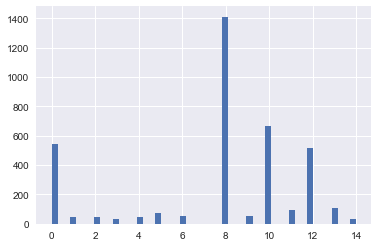

In [343]:
plt.hist(results4,bins=50)
plt.show()

In [344]:
# Sequential predictions with cross-validated class scores (1000 estimators)
results4 = np.full(X_test4.shape[0],-1)
classes = np.array(util.malware_classes)
n_classes = len(classes)
iclasses = np.arange(n_classes)
ih = np.arange(X_test4.shape[0])
for i in range(n_classes-1):
    print(i+1,')')
    # Fit classifier on current classes
    RF_vec4_ = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                      n_estimators=1000, max_features='sqrt')
    y_train_ = y_train[:,iclasses]
    ix = np.sum(y_train_,axis=1) > 0
    cv_scores_ = cross_val_score(RF_vec4_cv_, X_train4_all[ix,:], y_train_[ix,:], 
                                 cv=5, scoring=class_scorer)
    print('     ',cv_scores_)
    # Find smallest class with largest score
    class_cts = np.bincount(cv_scores_)
    imax = (class_cts == np.max(class_cts)).nonzero()[0]
    if len(imax) > 1:
        y_train_ = y_train[:,iclasses[imax]]
        imax = imax[np.argmin(np.sum(y_train_,axis=0))]
    else: imax = imax[0]
    print('     Best class: {:10s} ({:3d} elements)'.format(classes[imax],
        int(np.sum(y_train[:,iclasses[imax]],axis=0))))
    # Make predictions for best class
    RF_vec4_.fit(X_train4_all[ix,:], y_train_[ix,:])
    preds4_ = RF_vec4_.predict(X_test4[ih,:])
    results4_ = np.argmax(preds4_, axis=1)
    if i < n_classes-2:
        results4[ih[results4_ == imax]] = iclasses[imax]
        # Take out best class
        ih = ih[results4_ != imax]
        classes = np.delete(classes, imax)
        iclasses = np.delete(iclasses, imax)
    else:
        results4[ih] = iclasses[results4_]

1 )
      Mean class score: 0.590
      Mean class score: 0.632
      Mean class score: 0.699
      Mean class score: 0.628
      Mean class score: 0.624
      [ 6  3  3 10 14]
     Best class: FraudPack  ( 32 elements)
2 )
      Mean class score: 0.608
      Mean class score: 0.632
      Mean class score: 0.666
      Mean class score: 0.611
      Mean class score: 0.641
      [ 5  5  5  9 13]
     Best class: Lipler     ( 53 elements)
3 )
      Mean class score: 0.561
      Mean class score: 0.608
      Mean class score: 0.646
      Mean class score: 0.580
      Mean class score: 0.618
      [ 8  8  8  8 12]
     Best class: Swizzor    (542 elements)
4 )
      Mean class score: 0.519
      Mean class score: 0.578
      Mean class score: 0.608
      Mean class score: 0.536
      Mean class score: 0.600
      [ 6  6  6  6 11]
     Best class: None       (1609 elements)
5 )
      Mean class score: 0.532
      Mean class score: 0.665
      Mean class score: 0.687
      Mean class score: 0

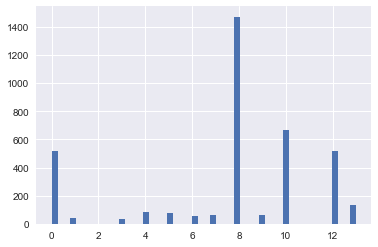

In [345]:
plt.hist(results4,bins=50)
plt.show()

In [346]:
print("writing predictions...")
util.write_predictions(results4, test_ids, 'AC_preds_9.csv')
reorder_submission('AC_preds_9.csv', "AC_results_9.csv")

writing predictions...
Reordered AC_preds_9.csv and wrote to AC_results_9.csv


In [363]:
# Shuffle training arrays
from sklearn.utils import shuffle
X_train4_shf = shuffle(X_train4_all,random_state=41)
y_train_shf  = shuffle(y_train,random_state=41)

In [371]:
# Sequential predictions with cross-validated class scores (1000 estimators, shuffled)
results4 = np.full(X_test4.shape[0],-1)
classes = np.array(util.malware_classes)
n_classes = len(classes)
iclasses = np.arange(n_classes)
ih = np.arange(X_test4.shape[0])
for i in range(n_classes-1):
    print(i+1,')')
    # Fit classifier on current classes
    RF_vec4_ = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                      n_estimators=1000, max_features='sqrt')
    y_train_ = y_train_shf[:,iclasses]
    ix = np.sum(y_train_,axis=1) > 0
    cv_scores_ = cross_val_score(RF_vec4_cv_, X_train4_shf[ix,:], y_train_[ix,:], 
                                 cv=5, scoring=class_scorer)
    print('     ',classes[cv_scores_])
    # Find smallest class with largest score
    class_cts = np.bincount(cv_scores_)
    imax = (class_cts == np.max(class_cts)).nonzero()[0]
    if len(imax) > 1:
        y_train_ = y_train_shf[:,iclasses[imax]]
        imax = imax[np.argmin(np.sum(y_train_,axis=0))]
    else: imax = imax[0]
    print('     Best class: {:10s} ({:3d} elements)'.format(classes[imax],
        int(np.sum(y_train_shf[:,iclasses[imax]],axis=0))))
    # Make predictions for best class
    RF_vec4_.fit(X_train4_shf[ix,:], y_train_[ix,:])
    preds4_ = RF_vec4_.predict(X_test4[ih,:])
    results4_ = np.argmax(preds4_, axis=1)
    if i < n_classes-2:
        results4[ih[results4_ == imax]] = iclasses[imax]
        # Take out best class
        ih = ih[results4_ != imax]
        classes = np.delete(classes, imax)
        iclasses = np.delete(iclasses, imax)
    else:
        results4[ih] = iclasses[results4_]
        imin = (classes != classes[imax]).nonzero()[0][0]
        print('     Remaining class: {:10s} ({:3d} elements)'.format(classes[imin],
            int(np.sum(y_train_shf[:,iclasses[imin]],axis=0))))

1 )
      Mean class score: 0.656
      Mean class score: 0.667
      Mean class score: 0.658
      Mean class score: 0.572
      Mean class score: 0.702
      ['FraudPack' 'FraudPack' 'FraudLoad' 'Lipler' 'AutoRun']
     Best class: FraudPack  ( 32 elements)
2 )
      Mean class score: 0.628
      Mean class score: 0.636
      Mean class score: 0.648
      Mean class score: 0.576
      Mean class score: 0.709
      ['Zbot' 'Swizzor' 'Lipler' 'Lipler' 'AutoRun']
     Best class: Lipler     ( 53 elements)
3 )
      Mean class score: 0.590
      Mean class score: 0.623
      Mean class score: 0.631
      Mean class score: 0.540
      Mean class score: 0.698
      ['Zbot' 'Swizzor' 'Swizzor' 'Swizzor' 'AutoRun']
     Best class: Swizzor    (542 elements)
4 )
      Mean class score: 0.572
      Mean class score: 0.603
      Mean class score: 0.577
      Mean class score: 0.509
      Mean class score: 0.648
      ['Zbot' 'Zbot' 'None' 'None' 'AutoRun']
     Best class: Zbot       ( 40 eleme

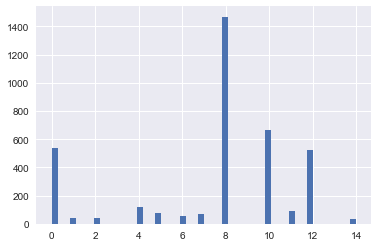

In [361]:
plt.hist(results4,bins=50)
plt.show()

## More feature engineering

## Correct number of tags per file

In [417]:
# Include 4-grams
vec4 = CountVectorizer(ngram_range=(1,4))
print('Feature extraction...')
X_train4_all = vec4.fit_transform(tags_train)
print(X_train4_all.shape)

Feature extraction...
(3086, 45279)


In [419]:
print('Feature extraction...')
X_test4 = vec4.transform(tags_test)
X_test4.shape

Feature extraction...


(3724, 45279)

In [418]:
# Global CV scores
RF_vec4_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                    n_estimators=1000, max_features='sqrt')
cv_scores = cross_val_score(RF_vec4_cv, X_train4_all, y_train, cv=5)
print(cv_scores)
print(np.mean(cv_scores))

[0.86245955 0.84116694 0.87358185 0.86061588 0.86385737]
0.8603363178129901


In [420]:
# Sequential predictions without CV
results4 = np.full(X_test4.shape[0],-1)
classes = np.array(util.malware_classes)
n_classes = len(classes)
iclasses = np.arange(n_classes)
ih = np.arange(X_test4.shape[0])
for i in range(n_classes-1):
    # Fit classifier on current classes
    RF_vec4_ = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                      n_estimators=1000, max_features='sqrt')
    y_train_ = y_train[:,iclasses]
    ix = np.sum(y_train_,axis=1) > 0
    RF_vec4_.fit(X_train4_all[ix,:], y_train_[ix,:])
    print(i+1,') Scores: Train ',RF_vec4_.score(X_train4_all[ix,:], y_train_[ix,:]))
    # Find smallest class with largest score  
    score = [RF_vec4_.score(X_train4_all[y_train[:,j]==1,:],
                            y_train_[y_train[:,j]==1,:]) for j in iclasses]
    imax = [np.argmax(score)]
    if len(imax) > 1:
        y_train_ = y_train[:,iclasses[imax]]
        imax = imax[np.argmin(np.sum(y_train_,axis=0))]
    else: imax = imax[0]
    print('     Best class: {:10s} ({:3d} elements). Score: {:.3f}'.format(classes[imax],
        int(np.sum(y_train[:,iclasses[imax]],axis=0)), score[imax]))
    # Make predictions for best class
    preds4_ = RF_vec4_.predict(X_test4[ih,:])
    results4_ = np.argmax(preds4_, axis=1)
    if i < n_classes-2:
        results4[ih[results4_ == imax]] = iclasses[imax]
        # Take out best class
        ih = ih[results4_ != imax]
        classes = np.delete(classes, imax)
        iclasses = np.delete(iclasses, imax)
    else:
        results4[ih] = iclasses[results4_]

1 ) Scores: Train  0.9792611795204148
     Best class: AutoRun    ( 50 elements). Score: 1.000
2 ) Scores: Train  0.9815546772068511
     Best class: FraudPack  ( 32 elements). Score: 1.000
3 ) Scores: Train  0.9816910785619174
     Best class: Lipler     ( 53 elements). Score: 1.000
4 ) Scores: Train  0.981362250084717
     Best class: Magania    ( 41 elements). Score: 1.000
5 ) Scores: Train  0.9810996563573883
     Best class: Swizzor    (542 elements). Score: 1.000
6 ) Scores: Train  0.9767736486486487
     Best class: Virut      ( 59 elements). Score: 1.000
7 ) Scores: Train  0.9770463404071026
     Best class: Zbot       ( 40 elements). Score: 1.000
8 ) Scores: Train  0.9784045835169678
     Best class: VB         (376 elements). Score: 0.997
9 ) Scores: Train  0.9756999471737982
     Best class: Agent      (114 elements). Score: 0.991
10 ) Scores: Train  0.9763912310286678
     Best class: None       (1609 elements). Score: 0.980
11 ) Scores: Train  0.9411764705882353
     Best 

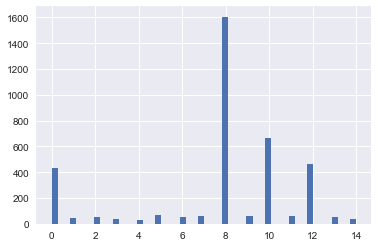

In [421]:
plt.hist(results4,bins=50)
plt.show()

In [422]:
print("writing predictions...")
util.write_predictions(results4, test_ids, 'AC_preds_10.csv')
reorder_submission('AC_preds_10.csv', "AC_results_10.csv")

writing predictions...
Reordered AC_preds_10.csv and wrote to AC_results_10.csv


In [424]:
# Sequential predictions with cross-validated class scores (1000 estimators)
results4 = np.full(X_test4.shape[0],-1)
classes = np.array(util.malware_classes)
n_classes = len(classes)
iclasses = np.arange(n_classes)
ih = np.arange(X_test4.shape[0])
for i in range(n_classes-1):
    print(i+1,')')
    # Fit classifier on current classes
    RF_vec4_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                      n_estimators=1000, max_features='sqrt')
    y_train_ = y_train[:,iclasses]
    ix = np.sum(y_train_,axis=1) > 0
    cv_scores_ = cross_val_score(RF_vec4_cv, X_train4_all[ix,:], y_train_[ix,:], 
                                 cv=5, scoring=class_scorer)
    print('     ',classes[cv_scores_])
    # Find smallest class with largest score
    class_cts = np.bincount(cv_scores_)
    imax = (class_cts == np.max(class_cts)).nonzero()[0]
    if len(imax) > 1:
        y_train_ = y_train[:,iclasses[imax]]
        imax = imax[np.argmin(np.sum(y_train_,axis=0))]
    else: imax = imax[0]
    print('     Best class: {:10s} ({:3d} elements)'.format(classes[imax],
        int(np.sum(y_train[:,iclasses[imax]],axis=0))))
    # Make predictions for best class
    RF_vec4_cv.fit(X_train4_all[ix,:], y_train_[ix,:])
    preds4_ = RF_vec4_cv.predict(X_test4[ih,:])
    results4_ = np.argmax(preds4_, axis=1)
    if i < n_classes-2:
        results4[ih[results4_ == imax]] = iclasses[imax]
        # Take out best class
        ih = ih[results4_ != imax]
        classes = np.delete(classes, imax)
        iclasses = np.delete(iclasses, imax)
    else:
        results4[ih] = iclasses[results4_]

1 )
      Mean class score: 0.608
      Mean class score: 0.672
      Mean class score: 0.733
      Mean class score: 0.662
      Mean class score: 0.662
      ['Lipler' 'FraudPack' 'AutoRun' 'Zbot' 'Zbot']
     Best class: Zbot       ( 40 elements)
2 )
      Mean class score: 0.630
      Mean class score: 0.625
      Mean class score: 0.722
      Mean class score: 0.625
      Mean class score: 0.637
      ['Lipler' 'FraudPack' 'AutoRun' 'Swizzor' 'Swizzor']
     Best class: Swizzor    (542 elements)
3 )
      Mean class score: 0.580
      Mean class score: 0.620
      Mean class score: 0.684
      Mean class score: 0.604
      Mean class score: 0.635
      ['Lipler' 'FraudPack' 'AutoRun' 'None' 'None']
     Best class: None       (1609 elements)
4 )
      Mean class score: 0.608
      Mean class score: 0.662
      Mean class score: 0.736
      Mean class score: 0.665
      Mean class score: 0.609
      ['Lipler' 'FraudPack' 'AutoRun' 'AutoRun' 'VB']
     Best class: AutoRun    ( 50 el

In [425]:
# Shuffle training arrays
from sklearn.utils import shuffle
X_train4_shf = shuffle(X_train4_all,random_state=41)
y_train_shf  = shuffle(y_train,random_state=41)

In [429]:
# Sequential predictions with cross-validated class scores (1000 estimators, shuffled)
results4 = np.full(X_test4.shape[0],-1)
classes = np.array(util.malware_classes)
n_classes = len(classes)
iclasses = np.arange(n_classes)
ih = np.arange(X_test4.shape[0])
for i in range(n_classes-1):
    print(i+1,')')
    # Fit classifier on current classes
    RF_vec4_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                        n_estimators=1000, max_features='sqrt')
    y_train_ = y_train_shf[:,iclasses]
    ix = np.sum(y_train_,axis=1) > 0
    cv_scores_ = cross_val_score(RF_vec4_cv, X_train4_shf[ix,:], y_train_[ix,:], 
                                 cv=5, scoring=class_scorer)
    print('     ',classes[cv_scores_])
    # Find smallest class with largest score
    class_cts = np.bincount(cv_scores_)
    imax = (class_cts == np.max(class_cts)).nonzero()[0]
    if len(imax) > 1:
        y_train_ = y_train_shf[:,iclasses[imax]]
        imax = imax[np.argmin(np.sum(y_train_,axis=0))]
    else: imax = imax[0]
    print('     Best class: {:10s} ({:3d} elements)'.format(classes[imax],
        int(np.sum(y_train_shf[:,iclasses[imax]],axis=0))))
    # Make predictions for best class
    RF_vec4_cv.fit(X_train4_shf[ix,:], y_train_[ix,:])
    preds4_ = RF_vec4_cv.predict(X_test4[ih,:])
    results4_ = np.argmax(preds4_, axis=1)
    if i < n_classes-2:
        results4[ih[results4_ == imax]] = iclasses[imax]
        # Take out best class
        ih = ih[results4_ != imax]
        classes = np.delete(classes, imax)
        iclasses = np.delete(iclasses, imax)
    else:
        results4[ih] = iclasses[results4_]
        imin = (classes != classes[imax]).nonzero()[0][0]
        print('     Remaining class: {:10s} ({:3d} elements)'.format(classes[imin],
            int(np.sum(y_train_shf[:,iclasses[imin]],axis=0))))

1 )
      Mean class score: 0.684
      Mean class score: 0.718
      Mean class score: 0.694
      Mean class score: 0.622
      Mean class score: 0.726
      ['FraudPack' 'FraudPack' 'FraudLoad' 'Lipler' 'AutoRun']
     Best class: FraudPack  ( 32 elements)
2 )
      Mean class score: 0.663
      Mean class score: 0.716
      Mean class score: 0.685
      Mean class score: 0.624
      Mean class score: 0.734
      ['Zbot' 'Swizzor' 'FraudLoad' 'Lipler' 'AutoRun']
     Best class: FraudLoad  ( 37 elements)
3 )
      Mean class score: 0.687
      Mean class score: 0.690
      Mean class score: 0.659
      Mean class score: 0.643
      Mean class score: 0.714
      ['Zbot' 'Swizzor' 'Lipler' 'Lipler' 'AutoRun']
     Best class: Lipler     ( 53 elements)
4 )
      Mean class score: 0.672
      Mean class score: 0.694
      Mean class score: 0.628
      Mean class score: 0.614
      Mean class score: 0.694
      ['Zbot' 'Swizzor' 'Swizzor' 'Swizzor' 'AutoRun']
     Best class: Swizzor    

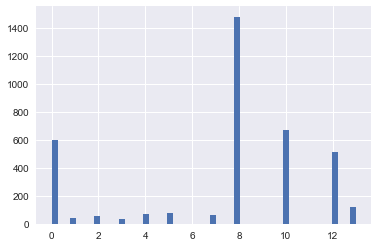

In [430]:
plt.hist(results4,bins=50)
plt.show()

## Drop features according to RF importance

In [27]:
# Repeated Stratified K-Fold cross validator
from sklearn.model_selection import RepeatedStratifiedKFold

In [451]:
n_repeats=2 # Number of KFold splits per loop
n_feat = X_train4_all.shape[1]
feat_ind = np.arange(n_feat)
n_feat_drop_pct = 100 # Keeps track of dropped features per loop
n_iter = 1
while n_feat_drop_pct > 0.1: # Stop when dropping <0.1% of features
    print('Iteration {}: {} features'.format(n_iter,n_feat))
    X_train4_ = X_train4_all[:,feat_ind]
    score = []
    feat_drop = np.ones(n_feat,dtype=bool)
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=10)
    for train_index, test_index in rskf.split(X_train4_, t_train):
        X_train_, X_test_ = X_train4_[train_index], X_train4_[test_index]
        y_train_, y_test_ = y_train[train_index], y_train[test_index]
        RF_vec4_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                            n_estimators=100, max_features='sqrt')
        RF_vec4_cv.fit(X_train_, y_train_)
        score.append(RF_vec4_cv.score(X_test_, y_test_))
        feat_drop = np.logical_and(feat_drop, RF_vec4_cv.feature_importances_ == 0)
    n_feat_drop = int(np.sum(feat_drop))
    n_feat_drop_pct = 100*n_feat_drop/n_feat
    print('   Mean score: {:.3f} +- {:.3f}. Features to drop: {} ({:.2f}%)'.format(np.mean(score),
        np.std(score),n_feat_drop,n_feat_drop_pct))
    feat_ind = feat_ind[np.logical_not(feat_drop)]
    n_feat = len(feat_ind)
    n_iter += 1
print('Done. Final number of features: ',n_feat)
# Create new dictionary
dict4_imp = {list(vec4.vocabulary_.keys())[list(vec4.vocabulary_.values()).index(ind0)]:i for i,ind0 in enumerate(feat_ind)}

Iteration 1: 45279 features
   Mean score: 0.860 +- 0.012. Features to drop: 21958 (48.49%)
Iteration 2: 23321 features
   Mean score: 0.861 +- 0.011. Features to drop: 5095 (21.85%)
Iteration 3: 18226 features
   Mean score: 0.860 +- 0.012. Features to drop: 2273 (12.47%)
Iteration 4: 15953 features
   Mean score: 0.860 +- 0.010. Features to drop: 1321 (8.28%)
Iteration 5: 14632 features
   Mean score: 0.861 +- 0.010. Features to drop: 867 (5.93%)
Iteration 6: 13765 features
   Mean score: 0.862 +- 0.010. Features to drop: 632 (4.59%)
Iteration 7: 13133 features
   Mean score: 0.860 +- 0.010. Features to drop: 489 (3.72%)
Iteration 8: 12644 features
   Mean score: 0.861 +- 0.011. Features to drop: 441 (3.49%)
Iteration 9: 12203 features
   Mean score: 0.861 +- 0.011. Features to drop: 321 (2.63%)
Iteration 10: 11882 features
   Mean score: 0.860 +- 0.010. Features to drop: 264 (2.22%)
Iteration 11: 11618 features
   Mean score: 0.861 +- 0.011. Features to drop: 235 (2.02%)
Iteration 1

   Mean score: 0.860 +- 0.011. Features to drop: 12 (0.15%)
Iteration 95: 7925 features
   Mean score: 0.863 +- 0.011. Features to drop: 8 (0.10%)
Iteration 96: 7917 features
   Mean score: 0.861 +- 0.010. Features to drop: 11 (0.14%)
Iteration 97: 7906 features
   Mean score: 0.861 +- 0.010. Features to drop: 10 (0.13%)
Iteration 98: 7896 features
   Mean score: 0.859 +- 0.011. Features to drop: 17 (0.22%)
Iteration 99: 7879 features
   Mean score: 0.861 +- 0.011. Features to drop: 15 (0.19%)
Iteration 100: 7864 features
   Mean score: 0.862 +- 0.010. Features to drop: 5 (0.06%)
Done. Final number of features:  7859


In [452]:
print('Feature extraction with new dictionary...')
vec4_imp = CountVectorizer(ngram_range=(1,4),vocabulary=dict4_imp)
X_train4_imp = vec4_imp.fit_transform(tags_train)
print(X_train4_imp.shape)
X_test4_imp = vec4_imp.transform(tags_test)
print(X_test4_imp.shape)

Feature extraction with new dictionary...
(3086, 7859)
(3724, 7859)


In [453]:
# Shuffle training arrays
X_train4_imp_shf = shuffle(X_train4_imp,random_state=41)
y_train_shf  = shuffle(y_train,random_state=41)

In [470]:
# Sequential predictions with cross-validated class scores (1000 estimators, shuffled)
results4 = np.full(X_test4_imp.shape[0],-1)
classes = np.array(util.malware_classes)
n_classes = len(classes)
iclasses = np.arange(n_classes)
ih = np.arange(X_test4_imp.shape[0])
for i in range(n_classes-1):
    print(i+1,')')
    # Fit classifier on current classes
    RF_vec4_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                        n_estimators=1000, max_features='sqrt')
    y_train_ = y_train_shf[:,iclasses]
    ix = np.sum(y_train_,axis=1) > 0
    cv_scores_ = cross_val_score(RF_vec4_cv, X_train4_imp_shf[ix,:], y_train_[ix,:], 
                                 cv=5, scoring=class_scorer)
    print('     ',classes[cv_scores_])
    # Find smallest class with largest score
    class_cts = np.bincount(cv_scores_)
    imax = (class_cts == np.max(class_cts)).nonzero()[0]
    if len(imax) > 1:
        y_train_ = y_train_shf[:,iclasses[imax]]
        imax = imax[np.argmin(np.sum(y_train_,axis=0))]
    else: imax = imax[0]
    # Make predictions for best class
    RF_vec4_cv.fit(X_train4_imp_shf[ix,:], y_train_[ix,:])
    preds4_ = RF_vec4_cv.predict(X_test4_imp[ih,:])
    results4_ = np.argmax(preds4_, axis=1)
    n_class_train = int(np.sum(y_train_shf[:,iclasses[imax]],axis=0))
    n_class_test = int(np.sum(results4_ == imax))
    print('     Best class: {:10s} ({:3d} files, {:.3f}% of training data)'.format(classes[imax],
        n_class_train, 100*n_class_train/y_train.shape[0]))
    print('        Classified test files: {}, {:.3f}% of test data'.format(n_class_test,
        100*n_class_test/X_test4_imp.shape[0]))
    if i < n_classes-2:
        results4[ih[results4_ == imax]] = iclasses[imax]
        # Take out best class
        ih = ih[results4_ != imax]
        classes = np.delete(classes, imax)
        iclasses = np.delete(iclasses, imax)
    else:
        results4[ih] = iclasses[results4_]
        imin = (classes != classes[imax]).nonzero()[0][0]
        n_class_train = int(np.sum(y_train_shf[:,iclasses[imin]],axis=0))
        n_class_test = int(np.sum(results4_ == imin))
        print('     Remaining class: {:10s} ({:3d} files, {:.3f}% of training data)'.format(classes[imin],
        n_class_train, 100*n_class_train/y_train.shape[0]))
    print('        Classified test files: {}, {:.3f}% of test data'.format(n_class_test,
        100*n_class_test/X_test4_imp.shape[0]))

1 )
      Mean class score: 0.701
      Mean class score: 0.740
      Mean class score: 0.706
      Mean class score: 0.621
      Mean class score: 0.743
      ['FraudPack' 'FraudPack' 'FraudLoad' 'Lipler' 'AutoRun']
     Best class: FraudPack  ( 32 files, 1.037% of training data)
        Classified test files: 38, 1.020% of test data
2 )
      Mean class score: 0.687
      Mean class score: 0.716
      Mean class score: 0.692
      Mean class score: 0.632
      Mean class score: 0.734
      ['Zbot' 'Swizzor' 'Lipler' 'Lipler' 'AutoRun']
     Best class: Lipler     ( 53 files, 1.717% of training data)
        Classified test files: 56, 1.504% of test data
3 )
      Mean class score: 0.670
      Mean class score: 0.701
      Mean class score: 0.673
      Mean class score: 0.607
      Mean class score: 0.713
      ['Zbot' 'Swizzor' 'FraudLoad' 'Swizzor' 'AutoRun']
     Best class: Swizzor    (542 files, 17.563% of training data)
        Classified test files: 668, 17.938% of test data
4 

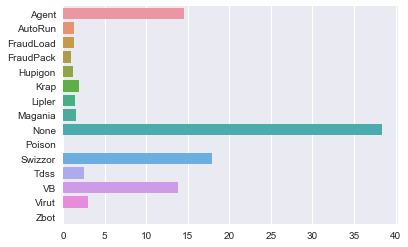

In [471]:
freq = 100*(np.bincount(results4))/len(results4)
freq = np.pad(freq, (0, 15 - len(freq)%15), 'constant')
sns.barplot(freq,np.arange(15),orient='h')
plt.yticks(range(len(util.malware_classes)),util.malware_classes)
plt.show()

In [468]:
print("writing predictions...")
util.write_predictions(results4, test_ids, 'AC_preds_11.csv')
reorder_submission('AC_preds_11.csv', "AC_results_11.csv")

writing predictions...
Reordered AC_preds_11.csv and wrote to AC_results_11.csv


## Get bags of system calls/processes with arguments

In [28]:
def get_calls(direc='data/train', with_actions=False, with_args=False, 
                      val_include=np.array([])):
    """
    Return a list with all "actions" (processes, with or without arguments) 
    for each file in a single string
    """
    calls = []
    classes = []
    ids = []
    for datafile in os.listdir(direc):
        # extract id and true class (if available) from filename
        id_str,clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))
        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)
        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        # Concatenate actions
        calls_str = ''
        in_all_section = False
        for el in tree.iter():
            if el.tag == 'processes':
                calls_str += '' #ignore
            elif (el.tag == 'process') & with_actions:
                calls_str += ('|' if calls_str != '' else '')+el.tag
                if with_args:
                    for key,val in sorted(el.attrib.items()):
                        calls_str += ' '+key+('="'+val+'"' if sum([key==val_include])>0 else '')
            #elif el.tag == "all_section" and not in_all_section:
            #    in_all_section = True
            #elif el.tag == 'all_section' and in_all_section:
            #    in_all_section = False
            #elif in_all_section:
            elif el.tag == 'all_section':
                calls_str += '' #ignore
            else:
                calls_str += ('|' if calls_str != '' else '')+el.tag
                if with_args:
                    for key,val in sorted(el.attrib.items()):
                        calls_str += ' '+key+('="'+val+'"' if sum([key==val_include])>0 else '')
        calls.append(calls_str)
    return calls, np.array(classes), ids

In [493]:
#val_include = np.array(['applicationtype','executionstatus','index','parentindex','startreason',
#                        'terminationreason','username'])
val_include = np.array(['filename'])
calls_train,t_train_,train_ids_ = get_calls('data/train',with_actions=True, with_args=True,
                                              val_include=val_include)

In [502]:
i0 = 892
print(train_ids_[i0], util.malware_classes[t_train_[i0]])
calls_train[i0]

5c2de0601774c5d0524e6adb694d9651580acd27f Lipler


'process applicationtype executionstatus filename="c:\\f94b0542d6b5a5f55a2425a2d7a39ae4.EX" filename_hash filesize index md5 parentindex pid sha1 startreason starttime terminationreason terminationtime username|thread tid|load_image address end_address filename="c:\\f94b0542d6b5a5f55a2425a2d7a39ae4.EX" filename_hash size successful|load_dll address end_address filename="C:\\WINDOWS\\system32\\ntdll.dll" filename_hash size successful|load_dll address end_address filename="C:\\WINDOWS\\system32\\kernel32.dll" filename_hash size successful|load_dll address end_address filename="C:\\WINDOWS\\system32\\USER32.dll" filename_hash size successful|load_dll address end_address filename="C:\\WINDOWS\\system32\\GDI32.dll" filename_hash size successful|load_dll address end_address filename="C:\\WINDOWS\\system32\\IMM32.DLL" filename_hash size successful|load_dll address end_address filename="C:\\WINDOWS\\system32\\ADVAPI32.dll" filename_hash size successful|load_dll address end_address filename="C:

In [505]:
# Include 3-grams
vec3_calls = CountVectorizer(calls_train, tokenizer=lambda x: x.split('|'), lowercase=False,
                             ngram_range=(1,4))
print('Feature extraction...')
X_train3 = vec3_calls.fit_transform(calls_train)
print(X_train3.shape)

Feature extraction...
(3086, 190750)


In [506]:
print('Feature extraction...')
X_test3 = vec3_calls.transform(tags_test)
X_test3.shape

Feature extraction...


(3724, 190750)

In [507]:
# Global CV scores
RF_vec3_calls_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                          n_estimators=1000, max_features='sqrt')
cv_scores = cross_val_score(RF_vec3_calls_cv, X_train3, y_train, cv=5)
print(cv_scores)
print(np.mean(cv_scores),np.std(cv_scores))

[0.87864078 0.85251216 0.88330632 0.88654781 0.88330632]
0.8768626772198708 0.012433442522978047


In [508]:
n_repeats=2 # Number of KFold splits per loop
n_feat = X_train3.shape[1]
feat_ind = np.arange(n_feat)
n_feat_drop_pct = 100 # Keeps track of dropped features per loop
n_iter = 1
while n_feat_drop_pct > 0.1: # Stop when dropping <0.1% of features
    print('Iteration {}: {} features'.format(n_iter,n_feat))
    X_train3_ = X_train3[:,feat_ind]
    score = []
    feat_drop = np.ones(n_feat,dtype=bool)
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=10)
    for train_index, test_index in rskf.split(X_train3_, t_train):
        X_train_, X_test_ = X_train3_[train_index], X_train3_[test_index]
        y_train_, y_test_ = y_train[train_index], y_train[test_index]
        RF_vec3_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                            n_estimators=100, max_features='sqrt')
        RF_vec3_cv.fit(X_train_, y_train_)
        score.append(RF_vec3_cv.score(X_test_, y_test_))
        feat_drop = np.logical_and(feat_drop, RF_vec3_cv.feature_importances_ == 0)
    n_feat_drop = int(np.sum(feat_drop))
    n_feat_drop_pct = 100*n_feat_drop/n_feat
    print('   Mean score: {:.3f} +- {:.3f}. Features to drop: {} ({:.2f}%)'.format(np.mean(score),
        np.std(score),n_feat_drop,n_feat_drop_pct))
    feat_ind = feat_ind[np.logical_not(feat_drop)]
    n_feat = len(feat_ind)
    n_iter += 1
print('Done. Final number of features: ',n_feat)
# Create new dictionary
dict3_imp = {list(vec3_calls.vocabulary_.keys())[list(vec3_calls.vocabulary_.values()).index(ind0)]:i for i,ind0 in enumerate(feat_ind)}

Iteration 1: 190750 features
   Mean score: 0.877 +- 0.010. Features to drop: 134054 (70.28%)
Iteration 2: 56696 features
   Mean score: 0.879 +- 0.012. Features to drop: 16532 (29.16%)
Iteration 3: 40164 features
   Mean score: 0.877 +- 0.009. Features to drop: 6449 (16.06%)
Iteration 4: 33715 features
   Mean score: 0.876 +- 0.008. Features to drop: 3551 (10.53%)
Iteration 5: 30164 features
   Mean score: 0.876 +- 0.011. Features to drop: 2321 (7.69%)
Iteration 6: 27843 features
   Mean score: 0.878 +- 0.010. Features to drop: 1715 (6.16%)
Iteration 7: 26128 features
   Mean score: 0.879 +- 0.009. Features to drop: 1211 (4.63%)
Iteration 8: 24917 features
   Mean score: 0.878 +- 0.012. Features to drop: 1035 (4.15%)
Iteration 9: 23882 features
   Mean score: 0.880 +- 0.010. Features to drop: 865 (3.62%)
Iteration 10: 23017 features
   Mean score: 0.875 +- 0.012. Features to drop: 714 (3.10%)
Iteration 11: 22303 features
   Mean score: 0.877 +- 0.011. Features to drop: 591 (2.65%)
Ite

   Mean score: 0.878 +- 0.011. Features to drop: 32 (0.23%)
Iteration 94: 13609 features
   Mean score: 0.879 +- 0.009. Features to drop: 32 (0.24%)
Iteration 95: 13577 features
   Mean score: 0.879 +- 0.010. Features to drop: 27 (0.20%)
Iteration 96: 13550 features
   Mean score: 0.877 +- 0.012. Features to drop: 26 (0.19%)
Iteration 97: 13524 features
   Mean score: 0.877 +- 0.011. Features to drop: 29 (0.21%)
Iteration 98: 13495 features
   Mean score: 0.879 +- 0.012. Features to drop: 13 (0.10%)
Done. Final number of features:  13482


In [509]:
print('Feature extraction with new dictionary...')
vec3_imp = CountVectorizer(ngram_range=(1,3),vocabulary=dict3_imp)
X_train3_imp = vec3_imp.fit_transform(tags_train)
print(X_train3_imp.shape)
X_test3_imp = vec3_imp.transform(tags_test)
print(X_test3_imp.shape)

Feature extraction with new dictionary...
(3086, 13482)
(3724, 13482)


In [510]:
# Shuffle training arrays
X_train3_imp_shf = shuffle(X_train3_imp,random_state=41)
y_train_shf  = shuffle(y_train,random_state=41)

In [512]:
# Sequential predictions with cross-validated class scores (1000 estimators, shuffled)
results3 = np.full(X_test3_imp.shape[0],-1)
classes = np.array(util.malware_classes)
n_classes = len(classes)
iclasses = np.arange(n_classes)
ih = np.arange(X_test3_imp.shape[0])
for i in range(n_classes-1):
    print(i+1,')')
    # Fit classifier on current classes
    RF_vec3_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                        n_estimators=1000, max_features='sqrt')
    y_train_ = y_train_shf[:,iclasses]
    ix = np.sum(y_train_,axis=1) > 0
    cv_scores_ = cross_val_score(RF_vec3_cv, X_train3_imp_shf[ix,:], y_train_[ix,:], 
                                 cv=5, scoring=class_scorer)
    print('     ',classes[cv_scores_])
    # Find smallest class with largest score
    class_cts = np.bincount(cv_scores_)
    imax = (class_cts == np.max(class_cts)).nonzero()[0]
    if len(imax) > 1:
        y_train_ = y_train_shf[:,iclasses[imax]]
        imax = imax[np.argmin(np.sum(y_train_,axis=0))]
    else: imax = imax[0]
    # Make predictions for best class
    RF_vec3_cv.fit(X_train3_imp_shf[ix,:], y_train_[ix,:])
    preds3_ = RF_vec3_cv.predict(X_test3_imp[ih,:])
    results3_ = np.argmax(preds3_, axis=1)
    n_class_train = int(np.sum(y_train_shf[:,iclasses[imax]],axis=0))
    n_class_test = int(np.sum(results3_ == imax))
    print('     Best class: {:10s} ({:3d} files, {:.3f}% of training data)'.format(classes[imax],
        n_class_train, 100*n_class_train/y_train.shape[0]))
    print('        Classified test files: {}, {:.3f}% of test data'.format(n_class_test,
        100*n_class_test/X_test3_imp.shape[0]))
    if i < n_classes-2:
        results3[ih[results3_ == imax]] = iclasses[imax]
        # Take out best class
        ih = ih[results3_ != imax]
        classes = np.delete(classes, imax)
        iclasses = np.delete(iclasses, imax)
    else:
        results3[ih] = iclasses[results3_]
        imin = (classes != classes[imax]).nonzero()[0][0]
        n_class_train = int(np.sum(y_train_shf[:,iclasses[imin]],axis=0))
        n_class_test = int(np.sum(results3_ == imin))
        print('     Remaining class: {:10s} ({:3d} files, {:.3f}% of training data)'.format(classes[imin],
        n_class_train, 100*n_class_train/y_train.shape[0]))
        print('        Classified test files: {}, {:.3f}% of test data'.format(n_class_test,
            100*n_class_test/X_test3_imp.shape[0]))

1 )
      Mean class score: 0.661
      Mean class score: 0.627
      Mean class score: 0.662
      Mean class score: 0.559
      Mean class score: 0.645
      ['Swizzor' 'Swizzor' 'Swizzor' 'Swizzor' 'AutoRun']
     Best class: Swizzor    (542 files, 17.563% of training data)
        Classified test files: 673, 18.072% of test data
2 )
      Mean class score: 0.624
      Mean class score: 0.603
      Mean class score: 0.642
      Mean class score: 0.514
      Mean class score: 0.620
      ['Magania' 'Zbot' 'Lipler' 'Lipler' 'AutoRun']
     Best class: Lipler     ( 53 files, 1.717% of training data)
        Classified test files: 57, 1.531% of test data
3 )
      Mean class score: 0.614
      Mean class score: 0.586
      Mean class score: 0.614
      Mean class score: 0.499
      Mean class score: 0.591
      ['Magania' 'Zbot' 'None' 'None' 'AutoRun']
     Best class: None       (1609 files, 52.139% of training data)
        Classified test files: 1280, 34.372% of test data
4 )
      

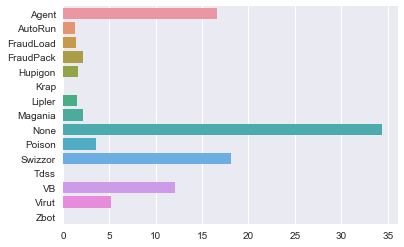

In [514]:
freq = 100*(np.bincount(results3))/len(results3)
freq = np.pad(freq, (0, 15 - len(freq)%15), 'constant')
sns.barplot(freq,np.arange(15),orient='h')
plt.yticks(range(len(util.malware_classes)),util.malware_classes)
plt.show()

In [515]:
print("writing predictions...")
util.write_predictions(results3, test_ids, 'AC_preds_12.csv')
reorder_submission('AC_preds_12.csv', "AC_results_12.csv")

writing predictions...
Reordered AC_preds_12.csv and wrote to AC_results_12.csv


## Implment bags of system calls

In [30]:
# Get bag of system calls (without arguments)
vec1_tags = CountVectorizer(lowercase=False)
print('Feature extraction (training data)...')
X_train1 = vec1_tags.fit_transform(tags_train)
print(X_train1.shape)
dict1_tags = vec1_tags.vocabulary_
print('Feature extraction (test data)...')
X_test1 = vec1_tags.transform(tags_test)
print(X_test1.shape)

Feature extraction (training data)...
(3086, 102)
Feature extraction (test data)...
(3724, 102)


In [536]:
ifeat_train = np.argsort(np.var(X_train1.toarray(),axis=0))[::-1]
ifeat_test  = np.argsort(np.var(X_test1.toarray(),axis=0))[::-1]
feat_var_train = [list(dict1_tags.keys())[list(dict1_tags.values()).index(ifeat0)] for ifeat0 in ifeat_train]
feat_var_test  = [list(dict1_tags.keys())[list(dict1_tags.values()).index(ifeat0)] for ifeat0 in ifeat_test]
print('Features with highest variance (Train Test):')
for i in range(len(feat_var_train)):
    print('{}. {:20s} {:20s}'.format(i+1,feat_var_train[i],feat_var_test[i]))

Features with highest variance (Train Test):
1. dump_line            load_dll            
2. vm_protect           sleep               
3. open_key             dump_line           
4. sleep                open_key            
5. load_dll             get_file_attributes 
6. find_file            find_file           
7. get_file_attributes  find_window         
8. query_value          query_value         
9. open_file            recv_socket         
10. find_window          trimmed_bytes       
11. delete_file          open_file           
12. recv_socket          vm_protect          
13. set_value            enum_window         
14. enum_window          set_value           
15. trimmed_bytes        open_process        
16. vm_read              vm_read             
17. read_value           com_create_instance 
18. enum_processes       delete_file         
19. open_mutex           enum_values         
20. com_create_instance  destroy_window      
21. enum_keys            enum_keys          

In [31]:
from itertools import combinations_with_replacement

In [44]:
n_bag = 3 # No. of items in a bag
bag_n = combinations_with_replacement(dict1_tags.keys(),n_bag)
dict_n = {key:i for i,key in enumerate(bag_n)}
print(len(dict_n))
n_train = X_train1.shape[0]
n_test  = X_test1.shape[0]
X_all_bag = np.zeros((n_train+n_test,len(dict_n)),dtype=np.int64)
X_all1 = sparse.vstack([X_train1,X_test1]).toarray()
print('filling...')
for bag0,icol0 in dict_n.items():
    if icol0 % 10000 == 0:
        print(icol0)
    ibag0 = np.array([dict1_tags[key] for key in bag0]) # Column indexes for keys in bag
    cts_all0 = np.ones(n_train+n_test,dtype=np.int64)
    for i,itag0 in enumerate(ibag0):
        # Subtract item repetitions in bag
        cts_all0 *= (X_all1[:,itag0]-np.sum(itag0==ibag0[0:i])).clip(min=0)
    X_all_bag[:,icol0] = cts_all0
# Scale data
print('scaling...')
X_all_bag = scale(X_all_bag,with_mean=False)
print(X_all_bag.shape)
print('thresholding features by variance...')
var = np.var(X_all_bag,axis=0)
ivar = np.argsort(var)[:np.sum(var < 0.5)-1:-1]
X_all_bag = X_all_bag[:,ivar]
print('creating new dictionary...')
dict_n1 = {list(dict_n.keys())[list(dict_n.values()).index(ivar0)]:i for i,ivar0 in enumerate(ivar)}
print('slicing...')
X_train_bag = sparse.csr_matrix(X_all_bag[:n_train],dtype=np.float32)
X_test_bag  = sparse.csr_matrix(X_all_bag[n_train:],dtype=np.float32)
print(X_train_bag.shape, X_test_bag.shape)
del X_all_bag, X_all1

182104
filling...
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
scaling...


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(6810, 182104)
thresholding features by variance...
creating new dictionary...
slicing...
(3086, 135918) (3724, 135918)


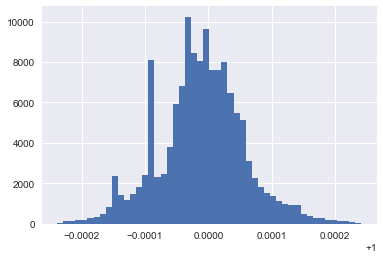

In [45]:
plt.hist(np.var(sparse.vstack([X_train_bag,X_test_bag]).toarray(),axis=0),bins=50)
plt.show()

In [53]:
# Global CV scores
RF_bag_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                   n_estimators=1000, max_features='sqrt')
cv_scores = cross_val_score(RF_bag_cv, X_train_bag, y_train, cv=5)
print(cv_scores)
print(np.mean(cv_scores),np.std(cv_scores))

[0.85760518 0.83144246 0.85251216 0.85575365 0.85575365]
0.8506134180946537 0.009724806518685045


In [62]:
n_repeats=2 # Number of KFold splits per loop
n_feat = X_train_bag.shape[1]
feat_ind = np.arange(n_feat)
n_feat_drop_pct = 100 # Keeps track of dropped features per loop
n_iter = 1
while n_feat_drop_pct > 0.1: # Stop when dropping <0.1% of features
    print('Iteration {}: {} features'.format(n_iter,n_feat))
    X_train_bag_ = X_train_bag[:,feat_ind]
    score = []
    feat_drop = np.ones(n_feat,dtype=bool)
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=10)
    for train_index, test_index in rskf.split(X_train_bag_, t_train):
        X_train_, X_test_ = X_train_bag_[train_index], X_train_bag_[test_index]
        y_train_, y_test_ = y_train[train_index], y_train[test_index]
        RF_bag_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                            n_estimators=100, max_features='sqrt')
        RF_bag_cv.fit(X_train_, y_train_)
        score.append(RF_bag_cv.score(X_test_, y_test_))
        feat_drop = np.logical_and(feat_drop, RF_bag_cv.feature_importances_ == 0)
    n_feat_drop = int(np.sum(feat_drop))
    n_feat_drop_pct = 100*n_feat_drop/n_feat
    print('   Mean score: {:.3f} +- {:.3f}. Features to drop: {} ({:.2f}%)'.format(np.mean(score),
        np.std(score),n_feat_drop,n_feat_drop_pct))
    feat_ind = feat_ind[np.logical_not(feat_drop)]
    n_feat = len(feat_ind)
    n_iter += 1
print('Done. Final number of features: ',n_feat)
# Slice feature matrices and create new dictionary
print('slicing matrices...')
X_train_bag = X_train_bag[:,feat_ind]
X_test_bag  = X_test_bag[:,feat_ind]
print('updating dictionary...')
dict_n1_imp = {list(dict_n1.keys())[list(dict_n1.values()).index(ind0)]:i for i,ind0 in enumerate(feat_ind)}

Iteration 1: 135918 features
   Mean score: 0.852 +- 0.009. Features to drop: 96620 (71.09%)
Iteration 2: 39298 features
   Mean score: 0.851 +- 0.007. Features to drop: 9263 (23.57%)
Iteration 3: 30035 features
   Mean score: 0.853 +- 0.008. Features to drop: 3688 (12.28%)
Iteration 4: 26347 features
   Mean score: 0.852 +- 0.009. Features to drop: 2149 (8.16%)
Iteration 5: 24198 features
   Mean score: 0.853 +- 0.009. Features to drop: 1371 (5.67%)
Iteration 6: 22827 features
   Mean score: 0.853 +- 0.009. Features to drop: 1076 (4.71%)
Iteration 7: 21751 features
   Mean score: 0.851 +- 0.009. Features to drop: 850 (3.91%)
Iteration 8: 20901 features
   Mean score: 0.851 +- 0.009. Features to drop: 656 (3.14%)
Iteration 9: 20245 features
   Mean score: 0.853 +- 0.009. Features to drop: 560 (2.77%)
Iteration 10: 19685 features
   Mean score: 0.852 +- 0.009. Features to drop: 484 (2.46%)
Iteration 11: 19201 features
   Mean score: 0.852 +- 0.008. Features to drop: 394 (2.05%)
Iteratio

   Mean score: 0.852 +- 0.010. Features to drop: 25 (0.19%)
Iteration 94: 13147 features
   Mean score: 0.852 +- 0.009. Features to drop: 24 (0.18%)
Iteration 95: 13123 features
   Mean score: 0.852 +- 0.010. Features to drop: 20 (0.15%)
Iteration 96: 13103 features
   Mean score: 0.854 +- 0.011. Features to drop: 17 (0.13%)
Iteration 97: 13086 features
   Mean score: 0.852 +- 0.009. Features to drop: 13 (0.10%)
Done. Final number of features:  13073
slicing matrices...
updating dictionary...


In [63]:
# Global CV scores
RF_bag_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                   n_estimators=1000, max_features='sqrt')
cv_scores = cross_val_score(RF_bag_cv, X_train_bag, y_train, cv=5)
print(cv_scores)
print(np.mean(cv_scores),np.std(cv_scores))

[0.85598706 0.82658023 0.85251216 0.8541329  0.85575365]
0.8489931970648247 0.011276157026745268


In [ ]:
# Sequential predictions with cross-validated class scores (1000 estimators, shuffled)
results = np.full(X_test_bag.shape[0],-1)
classes = np.array(util.malware_classes)
n_classes = len(classes)
iclasses = np.arange(n_classes)
ih = np.arange(X_test_bag.shape[0])
for i in range(n_classes-1):
    print(i+1,')')
    # Fit classifier on current classes
    RF_bag_cv = RandomForestClassifier(class_weight="balanced", n_jobs=-1,
                                        n_estimators=1000, max_features='sqrt')
    y_train_ = y_train[:,iclasses]
    ix = np.sum(y_train_,axis=1) > 0
    cv_scores_ = cross_val_score(RF_bag_cv, X_train_bag[ix,:], y_train_[ix,:], 
                                 cv=5, scoring=class_scorer)
    print('     ',classes[cv_scores_])
    # Find smallest class with largest score
    class_cts = np.bincount(cv_scores_)
    imax = (class_cts == np.max(class_cts)).nonzero()[0]
    if len(imax) > 1:
        y_train_ = y_train_shf[:,iclasses[imax]]
        imax = imax[np.argmin(np.sum(y_train_,axis=0))]
    else: imax = imax[0]
    # Make predictions for best class
    RF_bag_cv.fit(X_train_bag[ix,:], y_train_[ix,:])
    preds_ = RF_bag_cv.predict(X_test_bag[ih,:])
    results_ = np.argmax(preds_, axis=1)
    n_class_train = int(np.sum(y_train_shf[:,iclasses[imax]],axis=0))
    n_class_test = int(np.sum(results_ == imax))
    print('     Best class: {:10s} ({:3d} files, {:.3f}% of training data)'.format(classes[imax],
        n_class_train, 100*n_class_train/y_train.shape[0]))
    print('        Classified test files: {}, {:.3f}% of test data'.format(n_class_test,
        100*n_class_test/X_test_bag.shape[0]))
    if i < n_classes-2:
        results[ih[results_ == imax]] = iclasses[imax]
        # Take out best class
        ih = ih[results_ != imax]
        classes = np.delete(classes, imax)
        iclasses = np.delete(iclasses, imax)
    else:
        results[ih] = iclasses[results_]
        imin = (classes != classes[imax]).nonzero()[0][0]
        n_class_train = int(np.sum(y_train_shf[:,iclasses[imin]],axis=0))
        n_class_test = int(np.sum(results_ == imin))
        print('     Remaining class: {:10s} ({:3d} files, {:.3f}% of training data)'.format(classes[imin],
        n_class_train, 100*n_class_train/y_train.shape[0]))
        print('        Classified test files: {}, {:.3f}% of test data'.format(n_class_test,
            100*n_class_test/X_test_bag.shape[0]))

## Most frequent system calls

In [ ]:
vec1_calls = CountVectorizer(calls_train, tokenizer=lambda x: x.split('|'), lowercase=False,
                             ngram_range=(1,1))
print('Feature extraction...')
X_train1 = vec1_calls.fit_transform(calls_train)
print(X_train1.shape)